## Проект "Предсказания ДТП"

Вы — специалист по Data Sciense в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.
Идея решения задачи от заказчика: 
Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
Для модели выбрать тип виновника — только машина (car).
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
Для моделирования ограничиться данными за 2012 год — они самые свежие.
Обязательное условие — учесть фактор возраста автомобиля.
На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

**Краткое описание таблиц**

**collisions** — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

**parties** — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

**vehicles** — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Подключение к базе. Загрузка таблицы sql

### Импортируем необходимые нам библиотеки и функции

In [1]:
!pip install -q phik

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time


from sqlalchemy import create_engine 

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score, roc_curve, precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

import phik

In [3]:
RANDOM_STATE = 12

### Конфигурация для подключения к базе данных data-science-vehicle-db 

In [4]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [5]:
engine = create_engine(connection_string)

### Выведем названи таблиц, которые есть в базе данных.

In [6]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema='public'
      AND table_type='BASE TABLE';
'''   
tables = pd.read_sql_query(query, con=engine)   
tables

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


**Итог:** Произведено подключение к базе данных. Выведены названия таблиц, которые есть в данной базе. В базе данных содержаться четыре таблицы: case_ids, collisions, parties, vehicles, что соответсвует ER диаграмме.

## Проведение  первичного исследования таблиц

###  Загрузим примеры из всех таблиц базы данных data-science-vehicle-db, чтобы посмотреть есть в них данные, какие данные в них содержатся и соответсвуют ли они описанию базы данных. 

#### Таблица case_ids

In [7]:
query = '''
SELECT *
FROM case_ids
LIMIT 10;
'''

sample_case_ids = pd.read_sql_query(query, con=engine) 
sample_case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [8]:
query = '''
SELECT COUNT(*)
FROM case_ids;
'''

count_case_ids = pd.read_sql_query(query, con=engine) 
count_case_ids

,count
0,1400000


In [9]:
query = '''
SELECT DISTINCT db_year
FROM case_ids;
'''

uniq_year_case_ids = pd.read_sql_query(query, con=engine) 
uniq_year_case_ids

,db_year
0,2021


В таблице case_ids содержится два поля case_id	и db_year, что не соответсвует описанию, приведенному в ER диаграмме. Сase_id содержит уникальные номера происшествия, это ключ, по которому данная таблица соединяется с другими таблицами. В столбце db_year скорее всего указан год создания записи в базе.

#### Таблица collisions (общая информация о ДТП)

In [10]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

sample_collision = pd.read_sql_query(query, con=engine) 
sample_collision

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [11]:
query = '''
SELECT table_name, 
       column_name, 
       data_type 
FROM information_schema.columns
WHERE table_name IN ('collisions');
'''
colum_collisions = pd.read_sql_query(query, con=engine)
colum_collisions

,table_name,column_name,data_type
0,collisions,party_count,integer
1,collisions,intersection,integer
2,collisions,distance,real
3,collisions,collision_date,date
4,collisions,collision_time,time without time zone
5,collisions,location_type,text
6,collisions,collision_damage,text
7,collisions,case_id,text
8,collisions,pcf_violation_category,text
9,collisions,type_of_collision,text


In [12]:
query = '''
SELECT COUNT(*)
FROM collisions;
'''

count_collisions = pd.read_sql_query(query, con=engine) 
count_collisions

,count
0,1400000


In [13]:
query = '''
SELECT COUNT(DISTINCT case_id)
FROM collisions;
'''

count = pd.read_sql_query(query, con=engine) 
count

,count
0,1400000


В таблице collisions содержатся все столбцы, которые приведены в описании таблиц базы. Столбец case_id содержит уникальный номер происшествия, а также является внешним ключом, соединяющим данную таблицу с о всеми остальными таблицами, связь с таблицами vehicles и parties - один ко многим (одной уникальной записи в таблице collisions может соответствовать нескользо записей с таким же case_id в таблицах vehicles и parties), с таблицей case_ids один к одному (размерность таблиц соответствует, в обоих количенство записей - 1400000).

#### Таблица parties (информация об участниках ДТП)

In [14]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

sample_parties = pd.read_sql_query(query, con=engine) 
sample_parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [15]:
query = '''
SELECT COUNT(*)
FROM parties;
'''

count_parties = pd.read_sql_query(query, con=engine) 
count_parties

,count
0,2752408


Для проверки связи между таблицами parties и collisions. Связь между таблицами - один к многим (в одном ДТП может быть несколько участников). Чтобы проверить - посчитаем количество уникальных значений case_id в таблице parties, оно должно быть равным количеству строк в таблице collisions.

In [16]:
query = '''
SELECT COUNT(DISTINCT case_id)
FROM parties;
'''

count_case_parties = pd.read_sql_query(query, con=engine) 
count_case_parties

,count
0,1400000


В таблице parties (информация об участниках ДТП) содержатся все столбцы, которые приведены в описании таблиц базы, плюс столбец id - содержит уникальный номер записи.  Столбец case_id является внешним ключом и соединяет данную таблицу со всеми остальными таблицами.

#### Таблица vehicles (информация о пострадавших машинах)

In [17]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

sample_vehicles = pd.read_sql_query(query, con=engine) 
sample_vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [18]:
query = '''
SELECT COUNT(*)
FROM vehicles;
'''

count_vehicles = pd.read_sql_query(query, con=engine) 

count_vehicles

,count
0,1021234


In [19]:
query = '''
SELECT COUNT(DISTINCT id)
FROM vehicles;
'''
count_dist_id_vehicles = pd.read_sql_query(query, con=engine) 

count_dist_id_vehicles

,count
0,1021234


In [20]:
query = '''
SELECT COUNT(DISTINCT case_id)
FROM vehicles;
'''
count_dist_id_vehicles = pd.read_sql_query(query, con=engine) 

count_dist_id_vehicles

,count
0,792642


В таблице vehicles (информация о пострадавших машинах) содержатся все столбцы, которые приведены в описании таблиц базы, плюс столбец party_number - номер участника ДТП.  Столбец id - содержит уникальный номер записи. Столбец case_id является внешним ключом и соединяет данную таблицу со всеми остальными таблицами. Следует обратить внимание, что в уникальных номеров ДТП в данной таблице только 792642 против 1400000 в остальных таблицах.

**Итог:** Проведя первичное исследование таблиц получили следующее:

В данной базе данных 4 таблицы. Таблица case_ids - является связующей таблицей, в ней нет информации, которая нам необходима для предскзаний. Три другие таблицы: collisions (общая информация о ДТП), parties (информация об участниках ДТП), vehicles (информация о пострадавших машинах)- таблицы с информацией о самом ДТП, участниках и транспортных средствах. Все талицы связаны между собой по полю case_id. 

В таблице case_ids содержится два поля case_id и db_year, что не соответсвует описанию, приведенному в ER диаграмме. Сase_id содержит уникальные номера происшествия, это ключ, по которому данная таблица соединяется с другими таблицами. В столбце db_year скорее всего указан год создания записи в базе.

В таблице collisions содержатся все столбцы, которые приведены в описании таблиц базы. Столбец case_id содержит уникальный номер происшествия, а также является внешним ключом, соединяющим данную таблицу с о всеми остальными таблицами, связь с таблицами vehicles и parties - один ко многим (одной уникальной записи в таблице collisions может соответствовать нескользо записей с таким же case_id в таблицах vehicles и parties), с таблицей case_ids один к одному (размерность таблиц соответствует, в обоих количенство записей - 1400000).

В таблице parties (информация об участниках ДТП) содержатся все столбцы, которые приведены в описании таблиц базы, плюс столбец id - содержит уникальный номер записи.  Столбец case_id является внешним ключом и соединяет данную таблицу со всеми остальными таблицами.

В таблице vehicles (информация о пострадавших машинах) содержатся все столбцы, которые приведены в описании таблиц базы, плюс столбец party_number - номер участника ДТП.  Столбец id - содержит уникальный номер записи. Столбец case_id является внешним ключом и соединяет данную таблицу со всеми остальными таблицами. Следует обратить внимание, что в уникальных номеров ДТП в данной таблице только 792642 против 1400000 в остальных таблицах.


Для ответа на вопрос "Соответствует ли количество таблиц условию задачи?" веремся к исходной задаче.
По условию задачи - необходимо оценить риск ДТП по выбранному маршруту движения. Причем под риском вероятность ДТП с любым повреждением транспортного средства. Для оценки данного риска нам нужны данные как о поездках с ДТП, так и о безаварийных поездках. В предоставленном наборе данных данные только о поездках с ДТП и лицах вниновных и не виновных в них. Поэтому в рамках данной работы мы можем оценить вероятность виновности в ДТП, что в большей степени вляет не на риск ДТП, а скорее на страховые выплаты. Также можно поробовать выявить факторы, сочетание факторов, которые присутствовали в большинстве случаев ДТП, и если они присутствуют "выдавать" предупреждение.  

##  Статистический анализ факторов ДТП

### Выясним, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений (таблица collisions). 
Сначала следаем запрос sql, затем построим график

In [21]:
query = '''
SELECT DATE_TRUNC('month', collision_date) AS month,
       COUNT(case_id) AS count_collisions
FROM collisions
GROUP BY month;
'''

collision = pd.read_sql_query(query, con=engine) 
collision

,month,count_collisions
0,2009-01-01 00:00:00+03:00,35062
1,2009-02-01 00:00:00+03:00,34480
2,2009-03-01 00:00:00+03:00,36648
3,2009-04-01 00:00:00+04:00,35239
4,2009-05-01 00:00:00+04:00,36916
5,2009-06-01 00:00:00+04:00,34202
6,2009-07-01 00:00:00+04:00,35161
7,2009-08-01 00:00:00+04:00,34508
8,2009-09-01 00:00:00+04:00,35555
9,2009-10-01 00:00:00+04:00,37835


Данные представлены за период с января 2009 года по июль 2013 года, затем еще есть данные за март и июль 2020 года. Однако, начиная с июня 2012 года количество ДТП резка падает, скорее всего это связано с отссутсвием данных. Поэтому для корректного определения наибольшего количества ДТП по месяцам возьмем период с января 2009 года по декабрь 2011 года, опрделим среднее количество ДТП по месяцам за три года.

In [169]:
query = '''
WITH col AS
     (SELECT DATE_TRUNC('month', collision_date) AS date,
             COUNT(case_id) AS count_collisions
      FROM collisions
      WHERE EXTRACT(YEAR FROM collision_date) BETWEEN 2009 AND 2011
      GROUP BY date)

SELECT EXTRACT(MONTH FROM date)::int AS month,
       AVG(count_collisions) AS count_collisions_mean
FROM col
GROUP BY month;
'''

collision_avg = pd.read_sql_query(query, con=engine) 
collision_avg

,month,count_collisions_mean
0,1,33293.333333
1,2,32791.000000
2,3,35678.666667
3,4,33677.333333
4,5,35049.333333
5,6,33177.000000
6,7,33945.000000
7,8,34489.000000
8,9,34883.000000
9,10,37311.000000


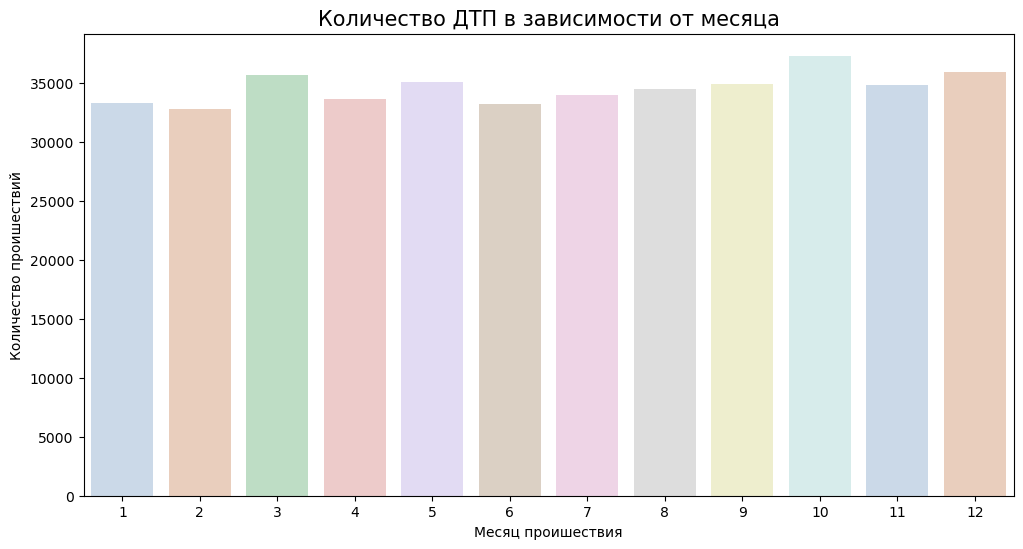

In [170]:
plt.figure(figsize=(12,6))
colors = sns.color_palette('pastel')
sns.barplot(data= collision_avg, x=collision_avg['month'], y=collision_avg['count_collisions_mean'],  palette=colors, saturation=0.5, alpha=0.7)
plt.title('Количество ДТП в зависимости от месяца', fontsize=15)
plt.xlabel('Месяц проишествия')
plt.ylabel('Количество проишествий')
plt.show()

**Вывод:** Наибольшее количество происшествий наблюдается в октябре месяце, затем следуют декабрь и март. 

### Для лучшего понимания данных, обозначим задачи, которые необходимо решить:
- провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
- найти самые частые причины ДТП (таблица collisions);
- найти наиболее опасные районы, где происходит наибольшее количество ДТП (таблица collisions);
- посмотреть зависимость между количеством ДТП и погодой (таблица collisions);
- посмотреть зависимость между количеством ДТП и состоянием дороги (таблица collisions);
- посмотреть с какими машинами (тип трансмиссии) происходить наибольшее количество ДТП в зависимости от состояния дороги (связать collisions и vehicle);
- автомобили с каким типом кузова чаще получают серьезные повреждения при ДТП (связать collisions и vehicle);
- провести анализ серьёзности повреждений транспортного средства в зависимости от состояния участника ДТП(party_drug_physical) (связь collisions и parties);
- регионы и самые частные причины нарушений (таблица collisions);
- регионы и соотношение водителей в зависимости от трезвости участника, party_type - только машины (связь collisions и parties);
- с автомобилями какого возраста чаще происходят происшествия (таблица vehicle);
- автомобили какого возраста чаще всего становятся виновниками ДТП (связать vehicle и parties).



### Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties)
1. Делаем sql запрос (отбираем в таблице collisions только происшествия с типом участника происшествия 'car', подситываем количество происшествий, группируем по состоянию дороги и внутри данных груп по типу серьезности повреждений);
2. Строим график;
3. Делаем вывод.


In [24]:
query = '''
WITH a AS
       (SELECT DISTINCT road_surface,
                        COUNT(*) AS cnt_collisions,
                        collision_damage
       
        FROM collisions
        WHERE case_id IN (SELECT case_id
                          FROM parties
                          WHERE party_type = 'car')
        GROUP BY road_surface, 
                 collision_damage
                 ORDER BY road_surface)
SELECT  road_surface,
        collision_damage,
        cnt_collisions,
        SUM(cnt_collisions) OVER (PARTITION BY road_surface) AS all_count
FROM a
                 
'''
cnt_collisions_road_surface = pd.read_sql_query(query, con=engine) 
cnt_collisions_road_surface['percent_cnt'] = cnt_collisions_road_surface['cnt_collisions']/cnt_collisions_road_surface['all_count']*100
cnt_collisions_road_surface

,road_surface,collision_damage,cnt_collisions,all_count,percent_cnt
0,dry,fatal,9746,1232957.0,0.790457
1,dry,severe damage,26965,1232957.0,2.187019
2,dry,middle damage,147189,1232957.0,11.937886
3,dry,scratch,306610,1232957.0,24.867858
4,dry,small damage,742447,1232957.0,60.216780
5,slippery,fatal,12,1359.0,0.883002
6,slippery,severe damage,60,1359.0,4.415011
7,slippery,middle damage,225,1359.0,16.556291
8,slippery,scratch,304,1359.0,22.369389
9,slippery,small damage,758,1359.0,55.776306


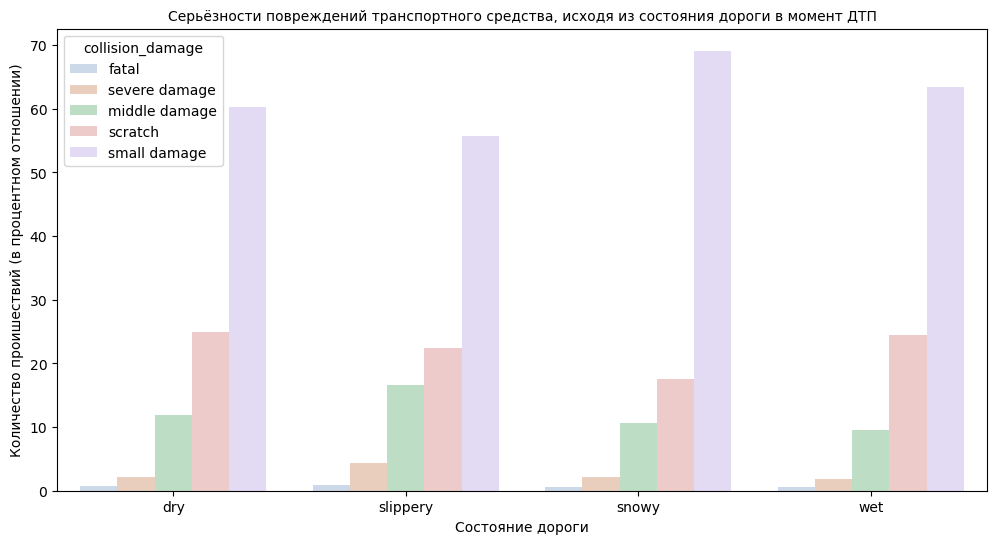

In [25]:
plt.figure(figsize=(12,6))
colors = sns.color_palette('pastel')
sns.barplot(data= cnt_collisions_road_surface, x='road_surface', y='percent_cnt', hue ='collision_damage', palette=colors, saturation=0.5, alpha=0.7)
plt.title('Cерьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП', fontsize=10)
plt.xlabel('Состояние дороги')
plt.ylabel('Количество проишествий (в процентном отношении)')
plt.show()

**Вывод:** В целом картина распределения серьезности происшествий в процентном соотношении похожа друг на друга в зависимости от состояния дороги. Наибольшее число мелкий повреждений, затем идут царапины, средние повреждения, серьезные повреждения и фатальные (машина не подлежит восстановлению). Но небольшие коллебания процентов внутри каждой группы в зависимости от состояния дороги наблюдаются. Например, при скользкой дороге возрастает процент фатальных, серьезных и средних повреждений, процент царапин и небольших повреждений уменьшается относительно распределения в сухую погоду.  При снеге уменьшается процент царапин, но увеличивается количество мелких повреждений относительно сухой погоды. В случае мокрой дороги падает процент средних повреждений, увеличивается процент легких повреждений. 

#### Найдем наиболее опасные районы, где происходит наибольшее количество ДТП 

In [26]:
query = '''
SELECT county_location,
       COUNT(case_id)
FROM collisions
GROUP BY county_location
ORDER BY COUNT(case_id) DESC;
'''

bad_location = pd.read_sql_query(query, con=engine)
bad_location

,county_location,count
0,los angeles,433809
1,orange,118276
2,san bernardino,79382
3,san diego,78391
4,riverside,69328
5,alameda,64553
6,sacramento,56988
7,santa clara,50786
8,ventura,32335
9,contra costa,31492


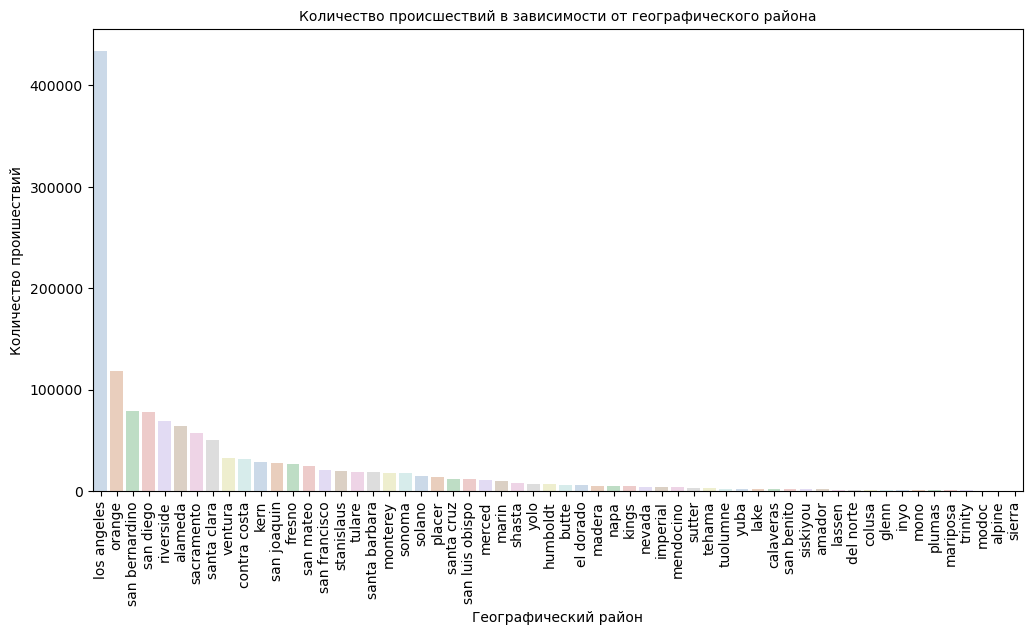

In [27]:
plt.figure(figsize=(12,6))
colors = sns.color_palette('pastel')
sns.barplot(data=bad_location, x='county_location', y='count',  palette=colors, saturation=0.5, alpha=0.7)
plt.title('Количество происшествий в зависимости от географического района', fontsize=10)
plt.xlabel('Географический район')
plt.ylabel('Количество проишествий')
plt.xticks(rotation=90)
plt.show()

**Вывод:** Видим, что наибольшее количество происшествий было зафиксированов Лос Анжелесе.

#### Посмотрим, с какими машинами (тип трансмиссии) происходить наибольшее количество ДТП в зависимости от состояния дороги (связать collisions и vehicle).
1. Делаем sql запрос (отбираем в таблице collisions только происшествия, которые являются общими для таблицы collisions и vehicle), подситываем количество происшествий, группируя по состоянию дороги и типу трансмисии);
2. Строим график;
3. Делаем вывод.

In [28]:
query = '''
WITH b AS
       (SELECT DISTINCT c.road_surface,
                        COUNT(*) AS cnt_collisions,
                        v.vehicle_transmission
        FROM collisions AS c
        JOIN vehicles AS v ON c.case_id = v.case_id
        GROUP BY c.road_surface, 
                 v.vehicle_transmission
                 ORDER BY c.road_surface)
                 
SELECT  road_surface,
        vehicle_transmission,
        cnt_collisions,
        SUM(cnt_collisions) OVER (PARTITION BY road_surface) AS all_count
FROM b                 
                 
                 
'''
cnt_vtr_road_surface = pd.read_sql_query(query, con=engine) 
cnt_vtr_road_surface['percent_cnt'] = cnt_vtr_road_surface['cnt_collisions']/cnt_vtr_road_surface['all_count']*100
cnt_vtr_road_surface

,road_surface,vehicle_transmission,cnt_collisions,all_count,percent_cnt
0,dry,None,21392,916827.0,2.333265
1,dry,manual,445186,916827.0,48.557252
2,dry,auto,450249,916827.0,49.109483
3,slippery,None,18,901.0,1.997780
4,slippery,auto,361,901.0,40.066593
5,slippery,manual,522,901.0,57.935627
6,snowy,None,49,4974.0,0.985123
7,snowy,manual,2457,4974.0,49.396864
8,snowy,auto,2468,4974.0,49.618014
9,wet,None,1888,89963.0,2.098641


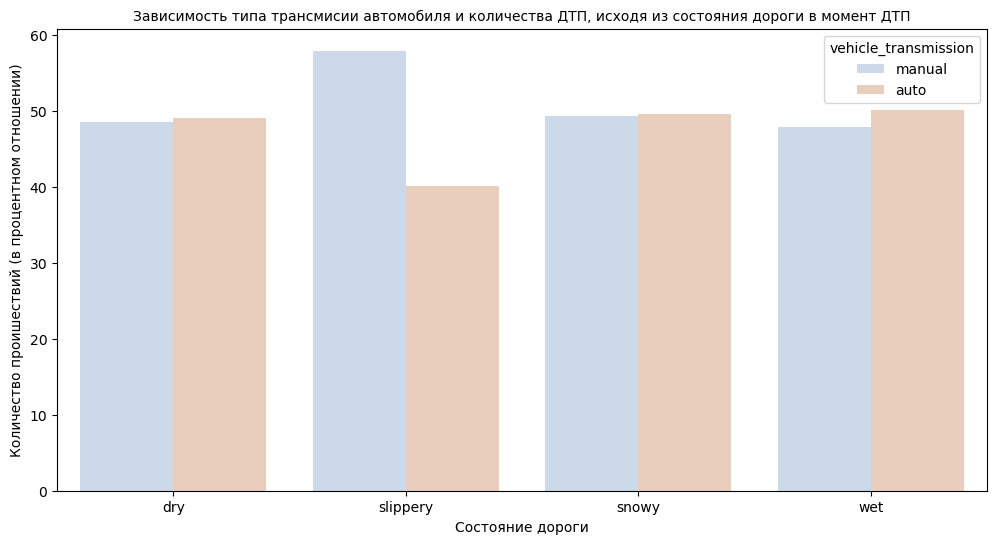

In [29]:
plt.figure(figsize=(12,6))
colors = sns.color_palette('pastel')
sns.barplot(data= cnt_vtr_road_surface, x='road_surface', y='percent_cnt', hue ='vehicle_transmission', palette=colors, saturation=0.5, alpha=0.7)
plt.title('Зависимость типа трансмисии автомобиля и количества ДТП, исходя из состояния дороги в момент ДТП', fontsize=10)
plt.xlabel('Состояние дороги')
plt.ylabel('Количество проишествий (в процентном отношении)')
plt.show()

**Вывод:** Из полученных данных видим, что транспортные средства с автоматической коробкой передач приблизительно одиниково ведут себя на сухой дороге и дороге, покрытой снегом. На мокрой дороге наблюдается небольшая разница, процент ДТП машин с автоматической коробкой передач чуть выше (около 2%, может быть обусловлен случайностью). А вот на скользкой дороге число ДТП с автоматической коробкой передач ниже, чем с механической.

#### Посмотри зависимость между повреждением при ДТП и типом кузова автомобиля, чтобы посмотреть автомобили с каким типом кузова чаще получают серьезные повреждения при ДТП.
1. Делаем sql запрос (отбираем в таблице collisions только происшествия, которые являются общими для таблицы collisions и vehicle), подситываем количество происшествий, группируя по серьезности происшествия и типу кузова);
2. Строим график;
3. Делаем вывод.

Посмотри сначала, машины с каким типом кузова чаще попадают в аварии.

In [30]:
query = '''
SELECT DISTINCT v.vehicle_type,
                COUNT(*) AS cnt_collisions
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id
GROUP BY v.vehicle_type
ORDER BY cnt_collisions
                 
        
'''
cnt_vtype = pd.read_sql_query(query, con=engine) 

cnt_vtype

,vehicle_type,cnt_collisions
0,other,1194
1,minivan,43000
2,hatchback,45595
3,coupe,442780
4,sedan,488665


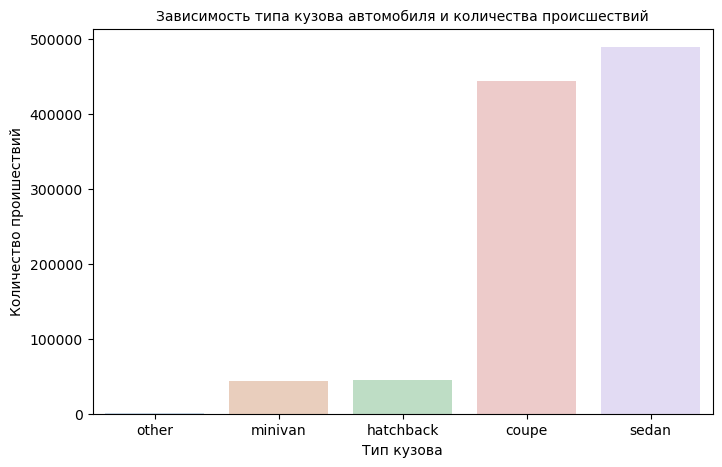

In [31]:
plt.figure(figsize=(8,5))
colors = sns.color_palette('pastel')
sns.barplot(data= cnt_vtype, x='vehicle_type', y='cnt_collisions',  palette=colors, saturation=0.5, alpha=0.7)
plt.title('Зависимость типа кузова автомобиля и количества происшествий', fontsize=10)
plt.xlabel('Тип кузова')
plt.ylabel('Количество проишествий')
plt.show()

**Вывод:** Наибольшее количество происшествий зафиксировано с машинами, у которых тип кузова седан, чуть меньше купе. 

In [32]:
query = '''
WITH t AS
       (SELECT DISTINCT c.collision_damage,
                        COUNT(*) AS cnt_collisions,
                        v.vehicle_type
        FROM collisions AS c
        JOIN vehicles AS v ON c.case_id = v.case_id
        GROUP BY c.collision_damage, 
                 v.vehicle_type
        ORDER BY c.collision_damage)
                 
SELECT  collision_damage,
        vehicle_type,
        cnt_collisions,
        SUM(cnt_collisions) OVER (PARTITION BY collision_damage) AS all_count
FROM t                 
                 
                 
'''
cnt_vtype_collision_damage = pd.read_sql_query(query, con=engine) 
cnt_vtype_collision_damage['percent_cnt'] = cnt_vtype_collision_damage['cnt_collisions']/cnt_vtype_collision_damage['all_count']*100
cnt_vtype_collision_damage

,collision_damage,vehicle_type,cnt_collisions,all_count,percent_cnt
0,fatal,other,22,15143.0,0.145282
1,fatal,minivan,527,15143.0,3.480156
2,fatal,hatchback,2786,15143.0,18.397940
3,fatal,sedan,2892,15143.0,19.097933
4,fatal,coupe,8916,15143.0,58.878690
5,middle damage,other,436,221523.0,0.196819
6,middle damage,hatchback,17576,221523.0,7.934165
7,middle damage,minivan,22046,221523.0,9.952014
8,middle damage,sedan,49979,221523.0,22.561540
9,middle damage,coupe,131486,221523.0,59.355462


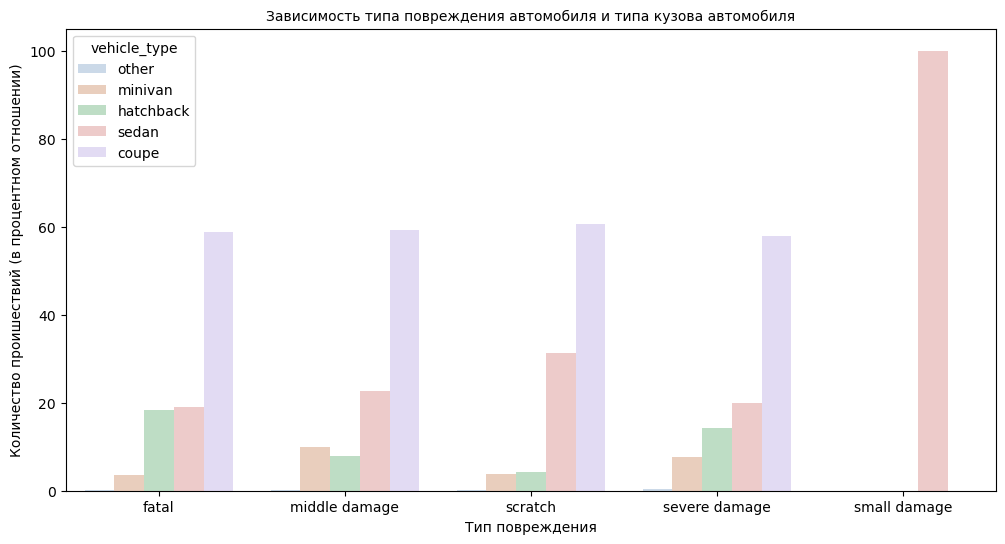

In [33]:
plt.figure(figsize=(12,6))
colors = sns.color_palette('pastel')
sns.barplot(data= cnt_vtype_collision_damage, x='collision_damage', y='percent_cnt', hue ='vehicle_type', palette=colors, saturation=0.5, alpha=0.7)
plt.title('Зависимость типа повреждения автомобиля и типа кузова автомобиля', fontsize=10)
plt.xlabel('Тип повреждения')
plt.ylabel('Количество проишествий (в процентном отношении)')
plt.show()

**Вывод:** Больше всего фатальных, серьезных и средных повреждений, а также царапин получили машины с типом кузова - купе, на втором месте с тпом кузова седан (это можно объяснить тем, что такие машины превышают количество minivan и hatchback, попавшиих в ДТП, где-то в 10 раз). Незначительные повреждения зафиксированы только у машин с типом кузова - седан. 

Посмотри еще распределение типов повреждений внутри групп по типу кузова автомобиля.

In [34]:
query = '''
WITH z AS
       (SELECT DISTINCT c.collision_damage,
                        COUNT(*) AS cnt_collisions,
                        v.vehicle_type
        FROM collisions AS c
        JOIN vehicles AS v ON c.case_id = v.case_id
        GROUP BY v.vehicle_type,
                 c.collision_damage 
                 
        ORDER BY v.vehicle_type)
                 
SELECT  vehicle_type,
        collision_damage,
        cnt_collisions,
        SUM(cnt_collisions) OVER (PARTITION BY vehicle_type) AS all_count
FROM z                 
                 
                 
'''
vtype_collision_damage = pd.read_sql_query(query, con=engine) 
vtype_collision_damage['percent_cnt'] = vtype_collision_damage['cnt_collisions']/vtype_collision_damage['all_count']*100
vtype_collision_damage

,vehicle_type,collision_damage,cnt_collisions,all_count,percent_cnt
0,coupe,fatal,8916,442780.0,2.013641
1,coupe,middle damage,131486,442780.0,29.695560
2,coupe,scratch,278571,442780.0,62.914088
3,coupe,severe damage,23807,442780.0,5.376711
4,hatchback,fatal,2786,45595.0,6.110319
5,hatchback,middle damage,17576,45595.0,38.548086
6,hatchback,scratch,19355,45595.0,42.449830
7,hatchback,severe damage,5878,45595.0,12.891764
8,minivan,fatal,527,43000.0,1.225581
9,minivan,middle damage,22046,43000.0,51.269767


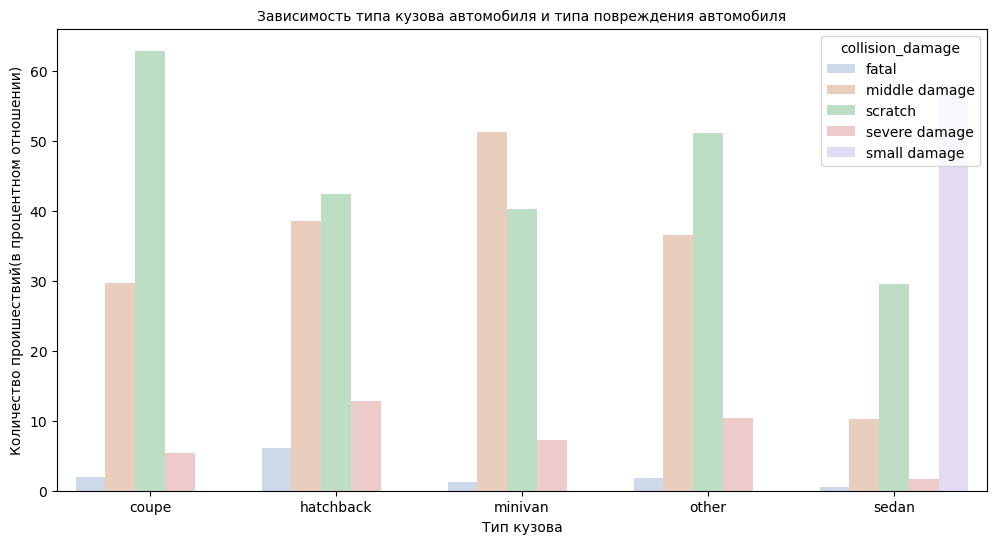

In [35]:
plt.figure(figsize=(12,6))
colors = sns.color_palette('pastel')
sns.barplot(data= vtype_collision_damage, x='vehicle_type', y='percent_cnt', hue ='collision_damage', palette=colors, saturation=0.5, alpha=0.7)
plt.title('Зависимость типа кузова автомобиля и типа повреждения автомобиля', fontsize=10)
plt.xlabel('Тип кузова')
plt.ylabel('Количество проишествий(в процентном отношении)')
plt.show()

**Вывод:** Общая тенденция - фатальные повреждения машины получают реже всего не зависимо от типа кузова машины, затем следуют серьезные повреждения. В отношении других типов повреждений ситуация немного меняется.
coupe - здесь смый высокий процент царапин среди всех типов-кузова.
Hatchback - здесь наблюдается самый высокий процент фатальных повреждений среди всех типов кузова.
minivan - здесь в отличии от других типов кузова, процент средних поврежденгий преобладает над процентом царапин, и выше чем в лругих категорях машин по типу кузова.
sedan - в имеющихся данных небольшие повреждения зафиксированы только у машин с кузовом седан.

**Итоговый вывод:** Из рассмотренных аналитических задач можно сдлеать следующие выводы.
1. Наибольшее количество происшествий наблюдается в октябре месяце, затем следуют декабрь и март.
2. Наибольшее количество происшествий было зафиксированов Лос Анжелесе.
3. В целом картина распределения серьезности происшествий в процентном соотношении похожа друг на друга в зависимости от состояния дороги. Наибольшее число мелкий повреждений, затем идут царапины, средние повреждения, серьезные повреждения и фатальные (машина не подлежит восстановлению). Но небольшие коллебания процентов внутри каждой группы в зависимости от состояния дороги наблюдаются. Например, при скользкой дороге возрастает процент фатальных, серьезных и средних повреждений, процент царапин и небольших повреждений уменьшается относительно распределения в сухую погоду. При снеге уменьшается процент царапин, но увеличивается количество мелких повреждений относительно сухой погоды. В случае мокрой дороги падает процент средних повреждений, увеличивается процент легких повреждений.
4. Из полученных данных видим, что транспортные средства с автоматической коробкой передач приблизительно одиниково ведут себя на сухой дороге и дороге, покрытой снегом. На мокрой дороге наблюдается небольшая разница, процент ДТП машин с автоматической коробкой передач чуть выше (около 2%, может быть обусловлен случайностью). А вот на скользкой дороге число ДТП с автоматической коробкой передач ниже, чем с механической.
5. Наибольшее количество происшествий зафиксировано с машинами, у которых тип кузова седан, чуть меньше купе. Больше всего фатальных, серьезных и средных повреждений, а также царапин получили машины с типом кузова - купе, на втором месте с тпом кузова седан (это можно объяснить тем, что такие машины превышают количество minivan и hatchback, попавшиих в ДТП, где-то в 10 раз). Незначительные повреждения зафиксированы только у машин с типом кузова - седан. 
При рассмотрении процентного соотношения типа повреждения внутри группы машин с одинаковы типом кузова получили следующее:  Общая тенденция - фатальные повреждения машины получают реже всего не зависимо от типа кузова машины, затем следуют серьезные повреждения. В отношении других типов повреждений ситуация немного меняется.
coupe - здесь смый высокий процент царапин среди всех типов-кузова.
Hatchback - здесь наблюдается самый высокий процент фатальных повреждений среди всех типов кузова.
minivan - здесь в отличии от других типов кузова, процент средних поврежденгий преобладает над процентом царапин, и выше чем в лругих категорях машин по типу кузова.
sedan - в имеющихся данных небольшие повреждения зафиксированы только у машин с кузовом седан. 


## Создание модели для оценки водительского риска

### С помощью sql запроса подготовим набор данных для создания и обучения моделей, основываясь на предположении заказчика: 

- 	Тип виновника — только машина (car). 
- 	Берем случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- 	Для моделирования берем данные только за 2012 год.


In [36]:
query ='''
SELECT   p.id,
         p.case_id,
         p.party_number,
         p.party_type,
         p.at_fault,
         p.insurance_premium,
         p.party_sobriety,
         p.party_drug_physical,
         p.cellphone_in_use,
         c.county_city_location,
         c.distance,
         c.direction,
         c.intersection,
         c.weather_1 AS weathe,
         c.location_type,
         c.collision_damage,
         c.party_count,
         c.primary_collision_factor,
         c.pcf_violation_category,
         c.type_of_collision,
         c.motor_vehicle_involved_with,
         c.road_surface,
         c.road_condition_1 AS road_condition,
         c.lighting,
         c.control_device,
         EXTRACT(MONTH FROM c.collision_date)::int as month,
         EXTRACT(HOUR FROM c.collision_time)::int as hour,
         v.vehicle_type,
         v.vehicle_transmission,
         v.vehicle_age
FROM parties AS P
JOIN vehicles AS v ON p.case_id=v.case_id AND p.party_number=v.party_number
JOIN collisions AS c ON p.case_id=c.case_id 
WHERE p.party_type = 'car' AND c.collision_damage != 'scratch' AND c.collision_date BETWEEN '2012-01-01' AND '2012-12-31' 
'''
df = pd.read_sql_query(query, con=engine) 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           56248 non-null  int64  
 1   case_id                      56248 non-null  object 
 2   party_number                 56248 non-null  int64  
 3   party_type                   56248 non-null  object 
 4   at_fault                     56248 non-null  int64  
 5   insurance_premium            55701 non-null  float64
 6   party_sobriety               55376 non-null  object 
 7   party_drug_physical          2857 non-null   object 
 8   cellphone_in_use             51777 non-null  float64
 9   county_city_location         56248 non-null  object 
 10  distance                     56248 non-null  float64
 11  direction                    43230 non-null  object 
 12  intersection                 56073 non-null  float64
 13  weathe          

### Напишем функцию для получения информации о датасете (вывод первых пяти срок, общей информации методом info(), описания информации в столбцах методом discribe(), построение гистограмм для визуализации распределения данных в столбцах), наличия явных дубликатов, построения матрицы корреляции с визуализацией в seaborn.¶

In [37]:
def get_info(data):
    display('Вывод первых 5-ти строк датасета', data.head())
    display(data.info())
    print('Количество явных дубликатов:' , data.duplicated().sum())
    print('Количество пропусков: \n', data.isna().sum())
    display(data.describe())
    data.hist(figsize=(9, 9));
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(data.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', 
                annot_kws={"fontsize":8})

'Вывод первых 5-ти строк датасета'

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,...,motor_vehicle_involved_with,road_surface,road_condition,lighting,control_device,month,hour,vehicle_type,vehicle_transmission,vehicle_age
0,2414417,5459031,2,car,0,26.0,had not been drinking,None,0.0,3600,...,non-collision,dry,normal,daylight,none,1,15.0,sedan,manual,3.0
1,2405996,5454652,2,car,0,22.0,had not been drinking,None,0.0,5400,...,other motor vehicle,dry,normal,daylight,none,1,6.0,sedan,manual,4.0
2,2412649,5458121,2,car,0,40.0,had not been drinking,None,0.0,5601,...,other motor vehicle,dry,normal,dark with street lights,none,1,18.0,sedan,auto,6.0
3,2413649,5458642,2,car,0,46.0,had not been drinking,None,0.0,2000,...,other object,dry,normal,daylight,functioning,2,10.0,sedan,auto,7.0
4,2413871,5458751,1,car,1,56.0,had not been drinking,None,0.0,3309,...,other motor vehicle,dry,normal,daylight,functioning,1,7.0,coupe,manual,9.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           56248 non-null  int64  
 1   case_id                      56248 non-null  object 
 2   party_number                 56248 non-null  int64  
 3   party_type                   56248 non-null  object 
 4   at_fault                     56248 non-null  int64  
 5   insurance_premium            55701 non-null  float64
 6   party_sobriety               55376 non-null  object 
 7   party_drug_physical          2857 non-null   object 
 8   cellphone_in_use             51777 non-null  float64
 9   county_city_location         56248 non-null  object 
 10  distance                     56248 non-null  float64
 11  direction                    43230 non-null  object 
 12  intersection                 56073 non-null  float64
 13  weathe          

None

Количество явных дубликатов: 0
Количество пропусков: 
 id                                 0
case_id                            0
party_number                       0
party_type                         0
at_fault                           0
insurance_premium                547
party_sobriety                   872
party_drug_physical            53391
cellphone_in_use                4471
county_city_location               0
distance                           0
direction                      13018
intersection                     175
weathe                           168
location_type                  30316
collision_damage                   0
party_count                        0
primary_collision_factor         111
pcf_violation_category           766
type_of_collision                308
motor_vehicle_involved_with      162
road_surface                     348
road_condition                   249
lighting                         154
control_device                   215
month               

,id,party_number,at_fault,insurance_premium,cellphone_in_use,distance,intersection,party_count,month,hour,vehicle_age
count,5.624800e+04,56248.000000,56248.000000,55701.000000,51777.000000,5.624800e+04,56073.000000,56248.000000,56248.000000,56160.000000,54554.000000
mean,2.594616e+06,1.527432,0.504427,37.607170,0.020357,8.594387e+02,0.221533,2.075025,3.233786,13.318145,4.856472
std,9.877649e+04,0.662507,0.499985,16.328721,0.141218,7.240295e+03,0.415282,0.798123,1.808481,5.526344,3.234503
min,1.800807e+06,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,0.000000,0.000000
25%,2.517333e+06,1.000000,0.000000,24.000000,0.000000,7.000000e+00,0.000000,2.000000,2.000000,10.000000,3.000000
50%,2.598362e+06,1.000000,1.000000,34.000000,0.000000,1.350000e+02,0.000000,2.000000,3.000000,14.000000,4.000000
75%,2.681091e+06,2.000000,1.000000,49.000000,0.000000,5.450000e+02,0.000000,2.000000,4.000000,17.000000,7.000000
max,2.752381e+06,9.000000,1.000000,105.000000,1.000000,1.584000e+06,1.000000,10.000000,12.000000,23.000000,161.000000


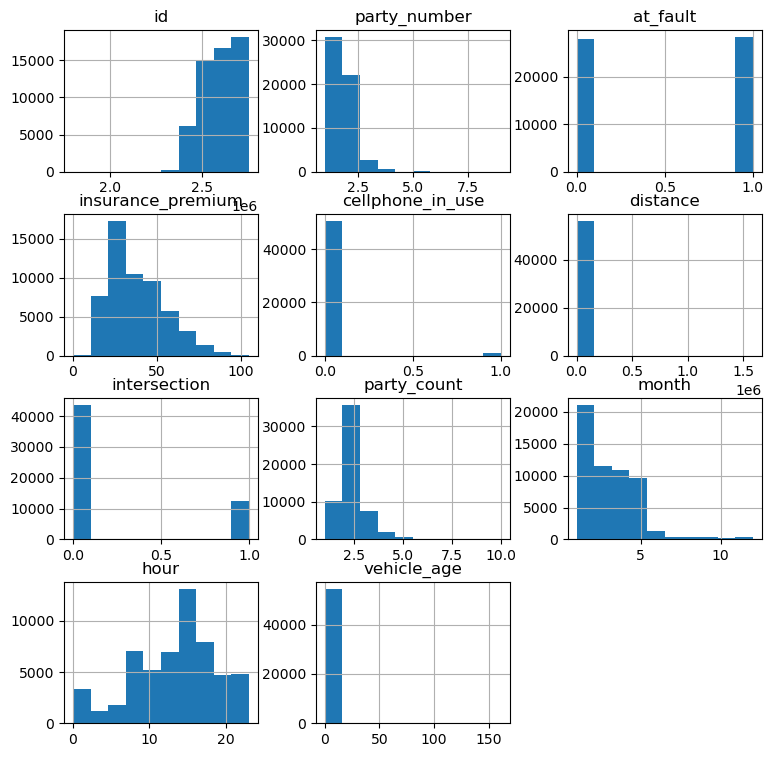

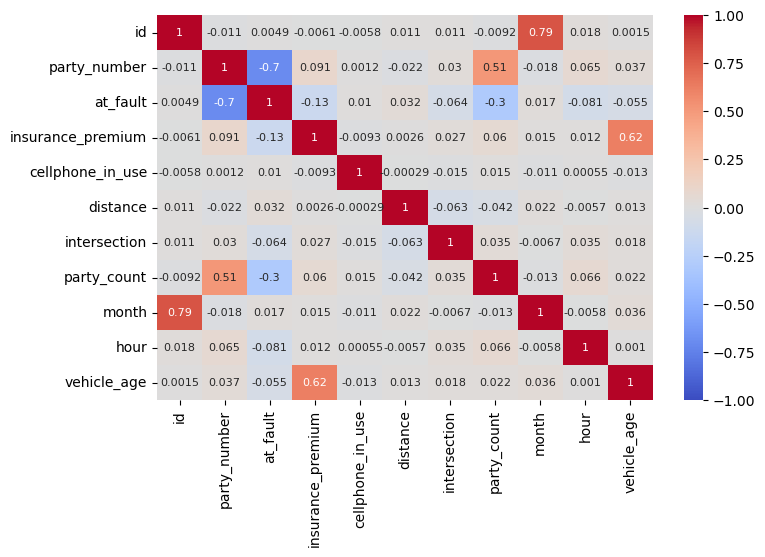

In [38]:
get_info(df)

### Так как в данном случае мало столбцов с числовыми признаками, попробуем использовать для оценки корреляции матрицу phik с визуализацией в seaborn

In [39]:
df.columns

Index(['id', 'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'county_city_location', 'distance', 'direction',
       'intersection', 'weathe', 'location_type', 'collision_damage',
       'party_count', 'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
       'road_condition', 'lighting', 'control_device', 'month', 'hour',
       'vehicle_type', 'vehicle_transmission', 'vehicle_age'],
      dtype='object')

In [40]:
phi=df[['at_fault','insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'county_city_location', 'distance', 'direction',
       'intersection', 'weathe', 'location_type', 'collision_damage',
       'party_count', 'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
       'road_condition', 'lighting', 'control_device', 'month', 'hour',
       'vehicle_type', 'vehicle_transmission', 'vehicle_age']].phik_matrix(interval_cols = ['insurance_premium','distance' ])


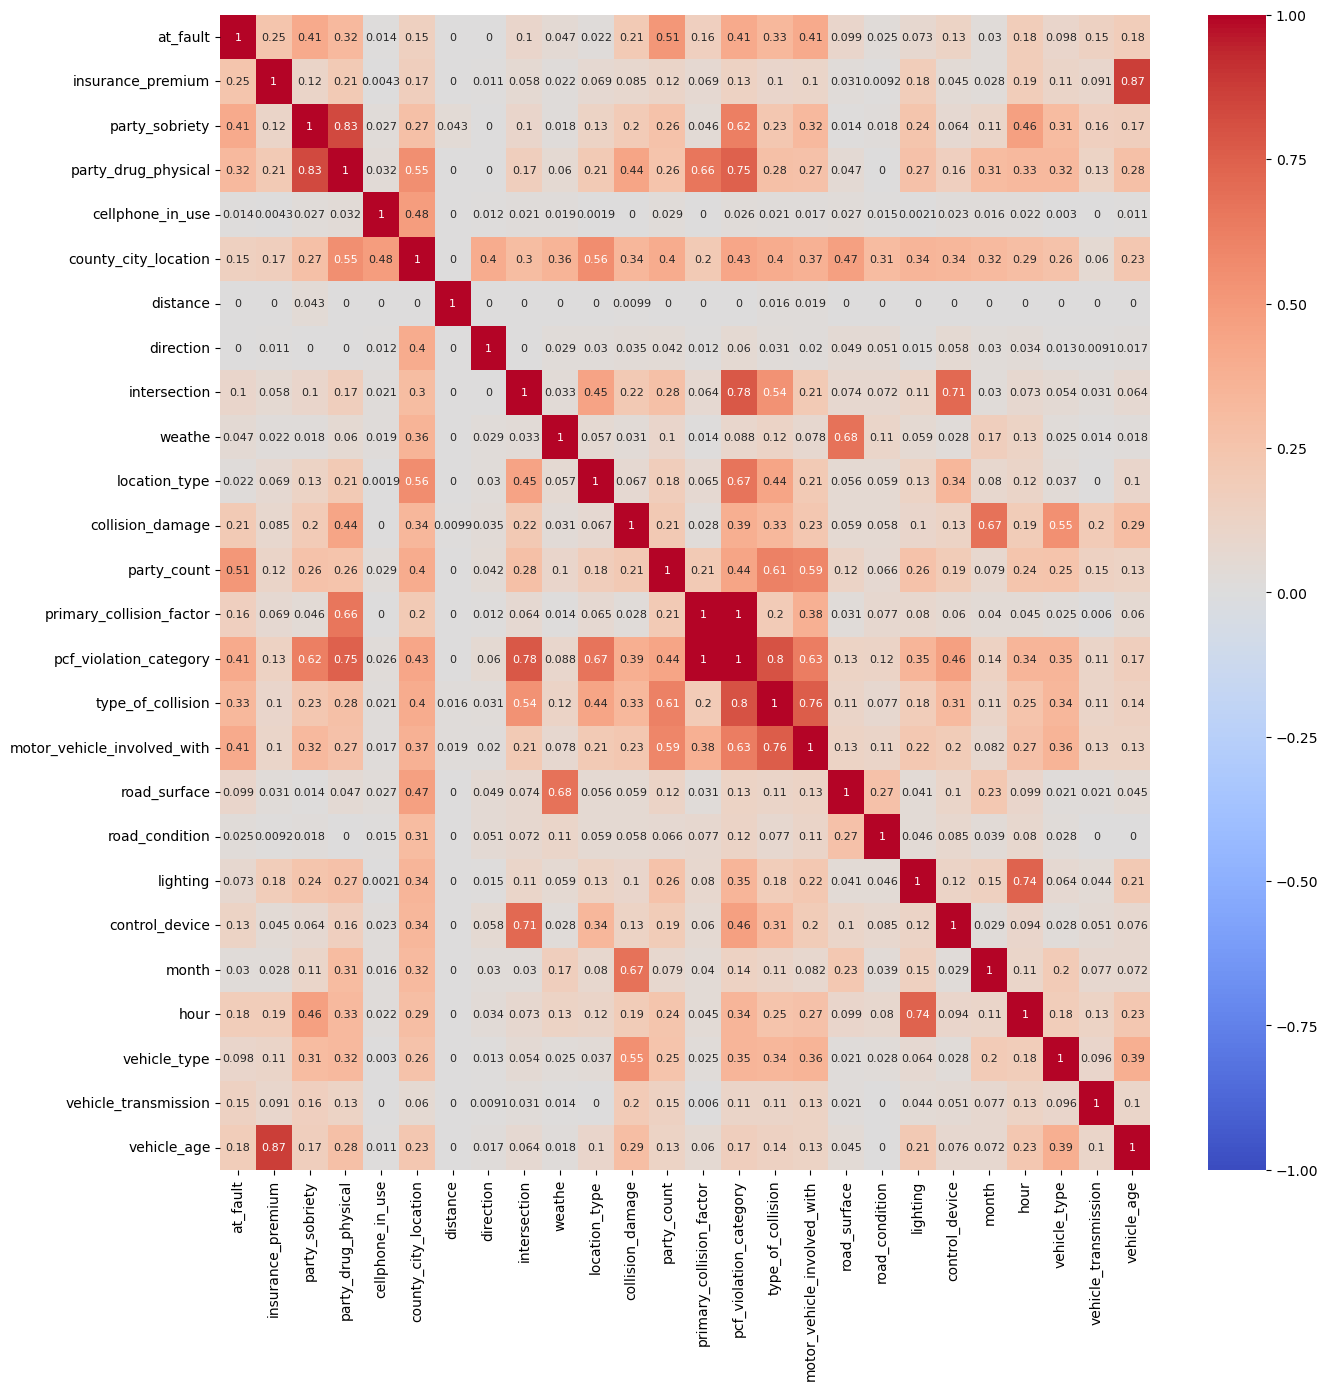

In [41]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(phi, annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', annot_kws={"fontsize":8});

**Вывод:** Из полученной инфоромации мы видем, что размер дата фрейиа - 56248 строк на 30 столбцов.В ряде столбцов есть пропуски их нужно будет обработать в дальнейшем. Дубликатов в таблице нет. Столбцы с форматом float64 надо перевести в int,т.к. в этих столбцах целые числа.  Значения в столбце party_type только одно car, следовательно его можно удалить, т.к. он не информативен (оставляла для проверки выведенных данных). Также можно удалить столбцы 'id', 'case_id', 'party_number', т.к. они также не информативны для обучения модели (оствляла для проверки выведенных данных). Из матрицы корреляции phik, что наибольшая зависимость прослеживается между суммой страховки и возрастом автомобиля (0.87) чем старше автомобиль, тем сумма выше, но думаю, что надо оставить оба фактора. А факторы 'primary_collision_factor', 'pcf_violation_category' по сути идентичны, оставим только один из них после более детального анализа. Прослеживается зависимость между type_of_collision (тип аварии) и pcf_violation_categor (категория нарушений) - 0.8, intersection и категорией нарушения (pcf_violation_categor) - 0.78, motor_vehicle_involved_with и type_of_collision - 0.76 и т.д. Наибольшая зависимость целевого признака at_fault (виновность водителя) прослеживается от трезвости участника (0.41), категории нарушения(0.41), дополнительных участников ДТП (0.41) и от количества участников ДТП(0.51). В столбцах 'distance', 'party_count', vehicle_age наблюдаются выбросы, изучим их более внимательно.

### Удалим не нужные столбцы и проверим еще раз на дубликаты

In [42]:
df = df.drop(['id', 'case_id', 'party_number', 'party_type'], axis=1)
df.shape

(56248, 26)

In [43]:
print('Количество явных дубликатов:' , df.duplicated().sum())

Количество явных дубликатов: 24


Удалим дубликаты

In [44]:
df= df.drop_duplicates().reset_index(drop=True)
len(df)

56224

### Рассмотрим целевой признак at_fault, посмотри соотношение классов в нем.

In [45]:
df['at_fault'].value_counts(normalize = True)

1    0.504553
0    0.495447
Name: at_fault, dtype: float64

Из полученных данных видим, что соотношение практически 50 на 50, дисбаланса классов нет.

### Рассмотрим party_sobriety, здесь есть пропуски. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown.

In [46]:
df['party_sobriety'].value_counts()

had not been drinking                     48555
had been drinking, under influence         4473
impairment unknown                         1238
had been drinking, not under influence      575
had been drinking, impairment unknown       261
not applicable                              250
Name: party_sobriety, dtype: int64

In [47]:
df['party_sobriety'] = df['party_sobriety'].fillna('unknown')
df['party_sobriety'].isna().sum()

0

Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце party_sobriety. Так как в данном случае речь идет о бинарном факторе, то конверсия по сути будет равно среднему. Так как подобные графики нам могут понадобится для других признаков, напишем функцию, которая принимает на вход датасет, столбец х по котору считаем конверсию (отношение количества лиц, виновных в ДТП к общему числу участников дтп), у - целевой признак (виновность  участника в ДТП)

In [48]:
def get_grath_convers (data, x, y):
    dt = df.groupby(x)[y].mean().reset_index()
    sns.barplot(x=dt[x], y=dt[y], palette=colors, saturation=0.5, alpha=0.7)
    plt.title(f'Отношение количества лиц, виновных в ДТП к общему числу участников ДТП по {x}', fontsize=10)
    plt.ylabel('конверсия')
    plt.xticks(rotation=90)
    plt.show()

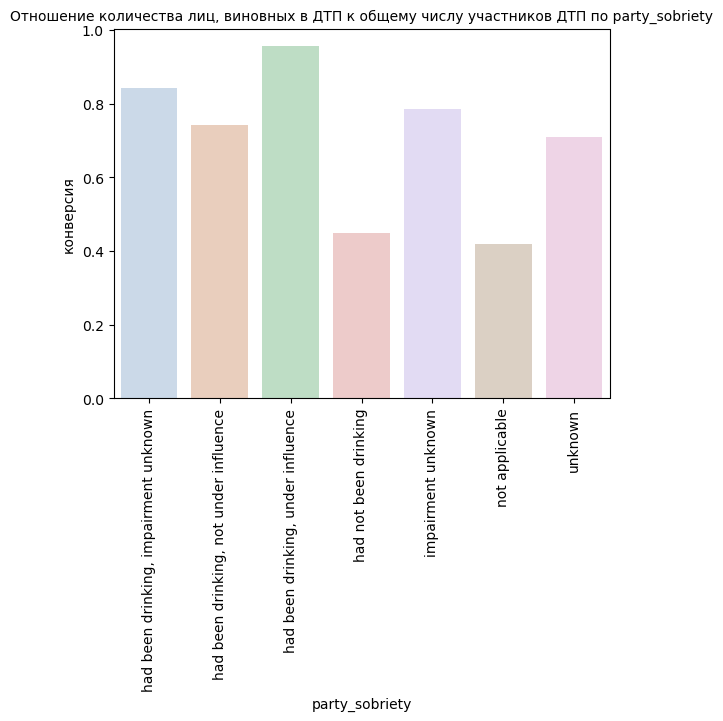

In [49]:
get_grath_convers(data=df, x='party_sobriety', y='at_fault')

**Вывод** - В данном случае прослеживается зависимость между фактором виновности в ДТП и трезвости участника. Чаще всего виновными оказываются лица из категории had been drinking, under influence.

### Рассмотрим party_drug_physical, здесь есть пропуски. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown, т.к. пропусков много, но данный фактор все-таки важен, т.к. оценивает состояние уатника ДТП.

In [50]:
df['party_drug_physical'].value_counts()

G                        1238
under drug influence      857
sleepy/fatigued           390
not applicable            250
impairment - physical     122
Name: party_drug_physical, dtype: int64

Не понятно, что означает G, но оставим данную категорию.

In [51]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('unknown')
df['party_drug_physical'].isna().sum()

0

Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце party_drug_physical.

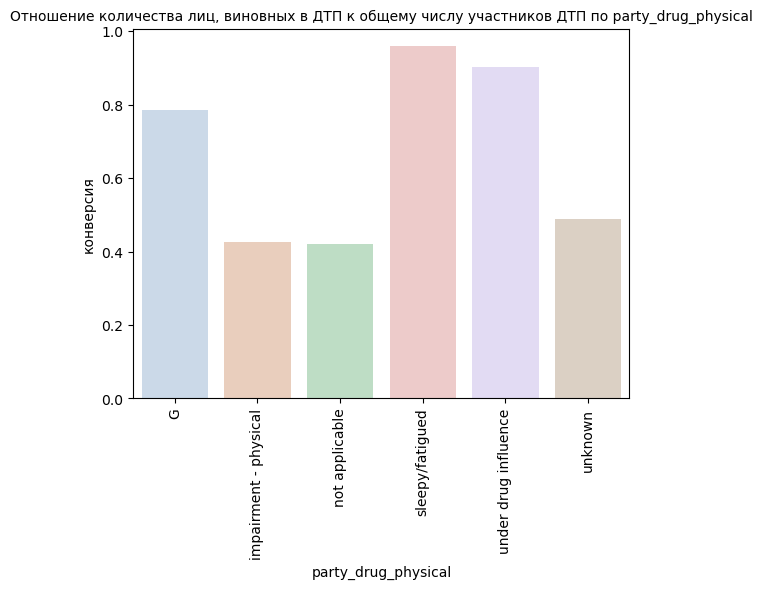

In [52]:
get_grath_convers(data=df, x='party_drug_physical', y='at_fault')

**Вывод** - В данном случае прослеживается зависимость между фактором виновности в ДТП и состоянием участника. Чаще всего виновными оказываются лица из категории sleepy/fatigued  и under drug influence.

### Рассмотрим cellphone_in_use. Данный столбец бинарный (значения 0 и 1), однако здесь есть пропуски.  Заполним пропуски значением 3 и переведем его тип в категориальный.

In [53]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna('3')
df['cellphone_in_use'].isna().sum()
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int')

In [54]:
df['cellphone_in_use'] = df['cellphone_in_use'].astype('category')


Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце cellphone_in_use.

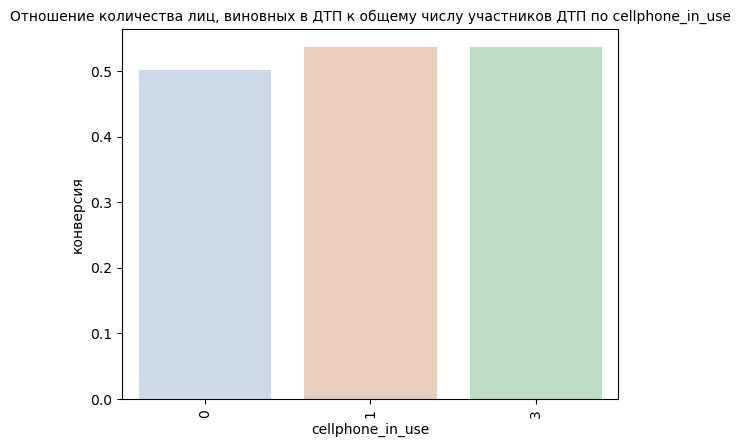

In [55]:
get_grath_convers(data=df, x='cellphone_in_use', y='at_fault')

**Вывод** - В данном случае не наблюдается особой разницы между категориями. Можно данный фактор и не учитывать при обучении модели, но пока его оставим.

### Рассмотрим county_city_location. Посмотрим уникальные значения и их количество

In [56]:
df['county_city_location'].value_counts()

1942    6930
1900    2234
3711    1338
3400    1087
3600    1007
        ... 
1504       1
0110       1
2803       1
1958       1
4701       1
Name: county_city_location, Length: 496, dtype: int64

**Вывод** - В данном столбце 496 значений. Виновность водителя скорее всего не зависит от географического места происшествия, удаляем этот столбец. Скорее он мог бы повлиять на вероятность ДТП, т.к. например плохие дороги или погодные условия в данной местности в определенное время года и т.п., но у нас остаются другие признаки, которые это описывают. Также коэффициент корреляции phik данного факторв с виновностью водителя - 0.15.

In [57]:
df = df.drop('county_city_location', axis=1)
df.shape

(56224, 25)

### Удаляем столбец 'distance', т.к. мне не очень понятен его смысл и матрица корреляции phik не выявила зависимость данного и целевого признака.

In [58]:
df = df.drop('distance', axis=1)
df.shape

(56224, 24)

### Рассмотрим direction, здесь есть пропуски. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown

In [59]:
df['direction'].value_counts()

north    12123
south    11879
west      9700
east      9507
Name: direction, dtype: int64

In [60]:
df['direction'] = df['direction'].fillna('unknown')
df['direction'].isna().sum()

0

Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце direction.

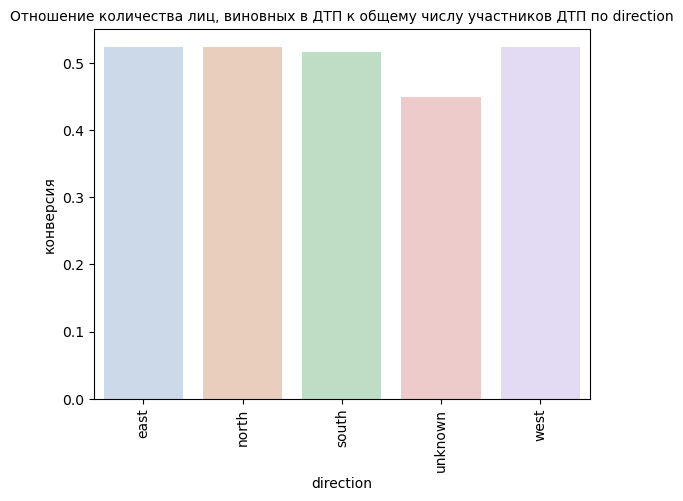

In [61]:
get_grath_convers(data=df, x='direction', y='at_fault')

**Вывод** - Конверсия не сильно изменяется в зависимости от направления движения, но пока оставим данный фактор, т.к. в сочетании с другими столбцами (например временем суток - светит солнце в глаза), он может болле значительно влиять на факт виновности.

### Удаляем столбец 'intersection', т.к. виновность участника вряд ли будет зависеть от того произошло ДТП на перекресте или нет, хотя на сам факт возникновения ДТП это скорее всего вляет. Корреляции phik таакже не выявила зависимость данного и целевого признака.

In [62]:
df = df.drop('intersection', axis=1)
df.shape

(56224, 23)

### Рассмотрим weathe , здесь есть пропуски. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown

In [63]:
df['weathe'].value_counts()

clear      45073
cloudy      8422
raining     2178
fog          181
snowing      157
other         34
wind          11
Name: weathe, dtype: int64

In [64]:
df['weathe'] = df['weathe'].fillna('unknown')
df['weathe'].isna().sum()

0

Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце weathe.

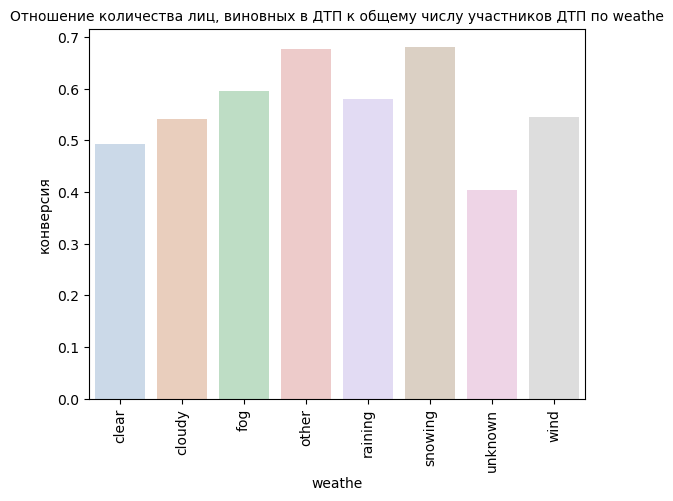

In [65]:
get_grath_convers(data=df, x='weathe', y='at_fault')

**Вывод** - В данном случае прослеживается зависимость между фактором виновности в ДТП и погодой.

### Рассмотрим location_type, здесь есть пропуски. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown

In [66]:
df['location_type'].value_counts()

highway         21311
ramp             3266
intersection     1341
Name: location_type, dtype: int64

In [67]:
df['location_type'] = df['location_type'].fillna('unknown')
df['location_type'].isna().sum()

0

Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце location_type.

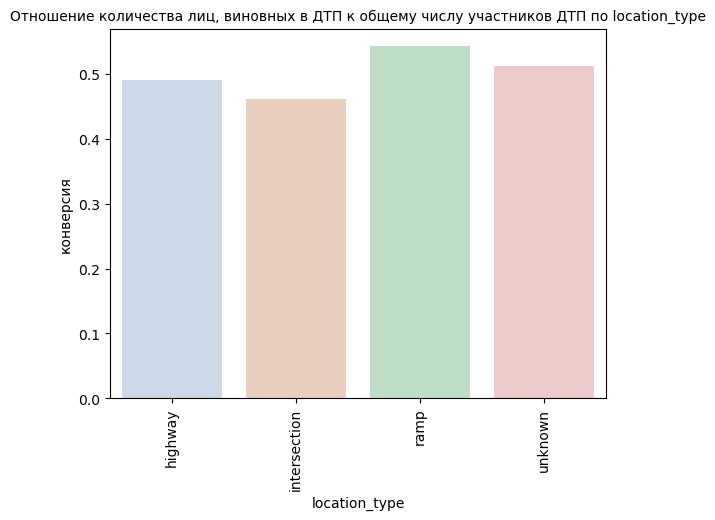

In [68]:
get_grath_convers(data=df, x='location_type', y='at_fault')

**Вывод** - Коллебания есть хоть и незначительные, пока оставим данный признак.

### Рассмотрим collision_damage. Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце collision_damage.

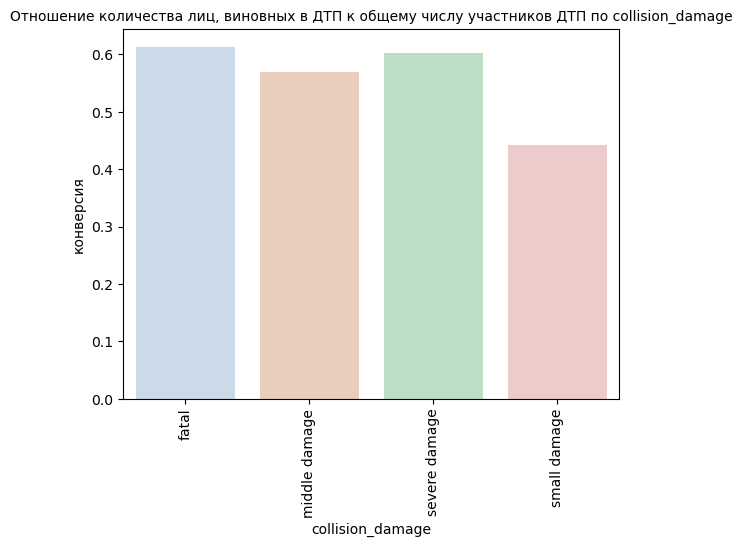

In [69]:
get_grath_convers(data=df, x='collision_damage', y='at_fault')

**Вывод** - Коллебания есть хоть и незначительные, пока оставим данный признак.

### Рассмотрим party_count, здесь также наблюдаются выбросы. Посмотрим уникальные значения и их количество. Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце party_count.

In [70]:
df['party_count'].value_counts()

2     35694
1     10167
3      7537
4      2016
5       584
6       144
7        43
8        19
9        17
10        3
Name: party_count, dtype: int64

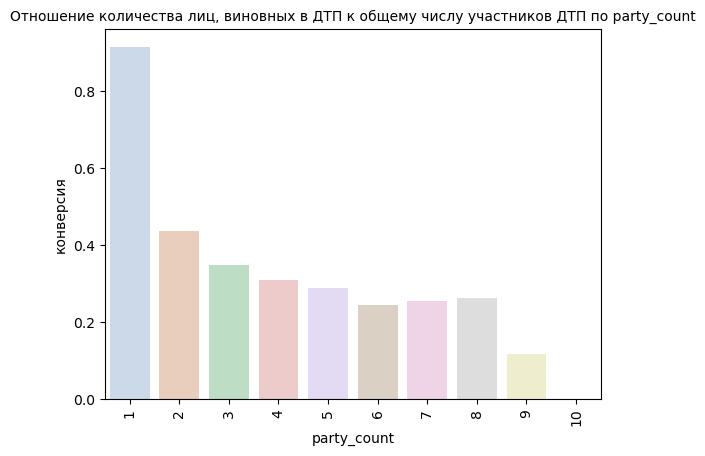

In [71]:
get_grath_convers(data=df, x='party_count', y='at_fault')

Удалим значения party_count > 6, т.к. они попадают в категорию выбросов (таких вариантов мало, они не типичные).

In [72]:
df = df.query('party_count <= 6')
len(df)

56142

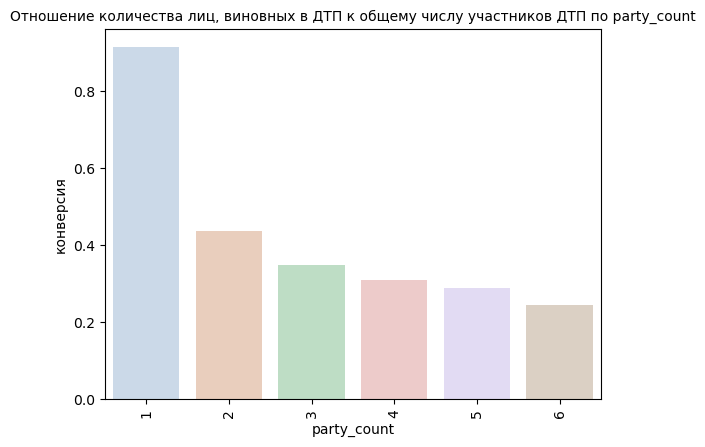

In [73]:
get_grath_convers(data=df, x='party_count', y='at_fault')

In [74]:
df['party_count'] = df['party_count'].astype('category')

### Рассмотрим primary_collision_factor. Посмотрим уникальные значения и их количество. Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце primary_collision_factor.

In [75]:
df['primary_collision_factor'].value_counts()

vehicle code violation    53813
other than driver          1148
unknown                     842
other improper driving      226
fell asleep                   3
Name: primary_collision_factor, dtype: int64

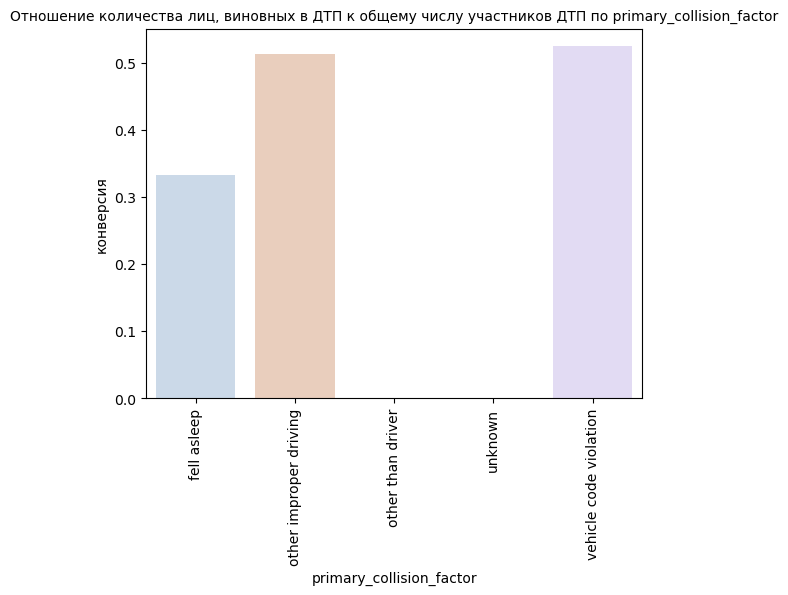

In [76]:
get_grath_convers(data=df, x='primary_collision_factor', y='at_fault')

In [77]:
df['pcf_violation_category'].value_counts()

speeding                             18197
improper turning                      8179
automobile right of way               7141
dui                                   6208
unsafe lane change                    4659
traffic signals and signs             3366
unsafe starting or backing            1380
wrong side of road                    1374
other than driver (or pedestrian)     1148
following too closely                 1011
unknown                                904
other hazardous violation              516
improper passing                       477
pedestrian violation                   314
other improper driving                 226
pedestrian right of way                112
other equipment                         84
impeding traffic                        33
hazardous parking                       32
brakes                                  10
fell asleep                              3
lights                                   3
Name: pcf_violation_category, dtype: int64

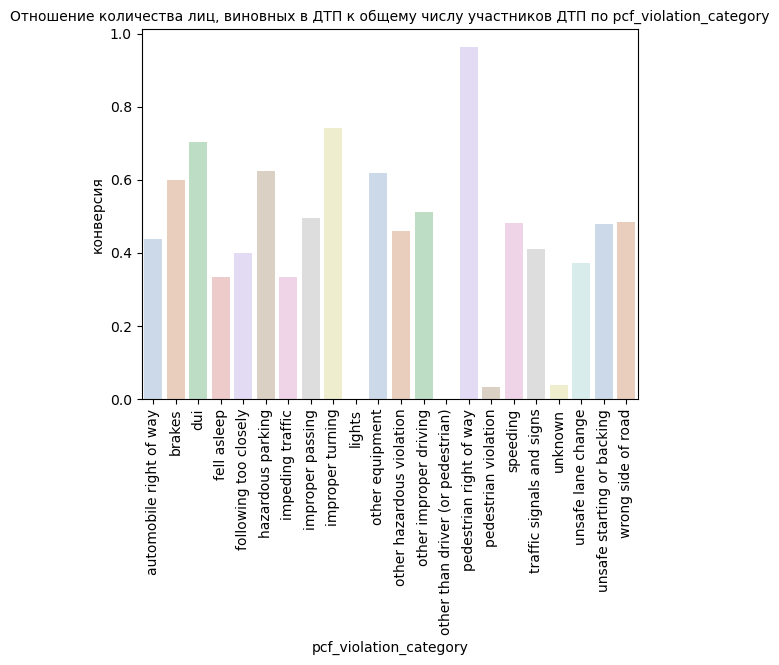

In [78]:
get_grath_convers(data=df, x='pcf_violation_category', y='at_fault')

Оставляем признак 'pcf_violation_category' как более информативный и понятный. Признак primary_collision_factor удаляем. Заполняем пропуски в 'pcf_violation_category' unknown.

In [79]:
df = df.drop('primary_collision_factor', axis=1)
df.shape

(56142, 22)

In [80]:
df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown')
df['pcf_violation_category'].isna().sum()

0

### Рассмотрим type_of_collision. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown/ Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце type_of_collision.¶

In [81]:
df['type_of_collision'].value_counts()

rear end      18721
broadside     11935
sideswipe      9236
hit object     8652
head-on        3269
overturned     2298
other          1723
Name: type_of_collision, dtype: int64

In [82]:
df['type_of_collision'] = df['type_of_collision'].fillna('unknown')
df['type_of_collision'].isna().sum()

0

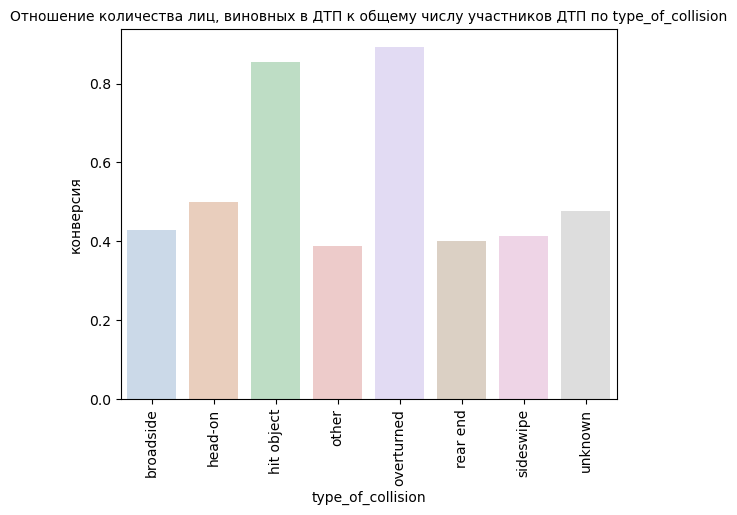

In [83]:
get_grath_convers(data=df, x='type_of_collision', y='at_fault')

**Вывод** - относительноен количество виновников ДТП явно отличается в зависимости от типа происшествия. Самый большой процент виновных при следующих типах повреждения - overturned и hit object. 

### Рассмотрим motor_vehicle_involved_with. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown/ Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце motor_vehicle_involved_with.¶

In [84]:
df['motor_vehicle_involved_with'].value_counts()

other motor vehicle               41107
fixed object                       8299
non-collision                      2276
other object                       1704
parked motor vehicle               1515
bicycle                             418
motor vehicle on other roadway      414
animal                              231
train                                16
Name: motor_vehicle_involved_with, dtype: int64

In [85]:
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].fillna('unknown')
df['motor_vehicle_involved_with'].isna().sum()

0

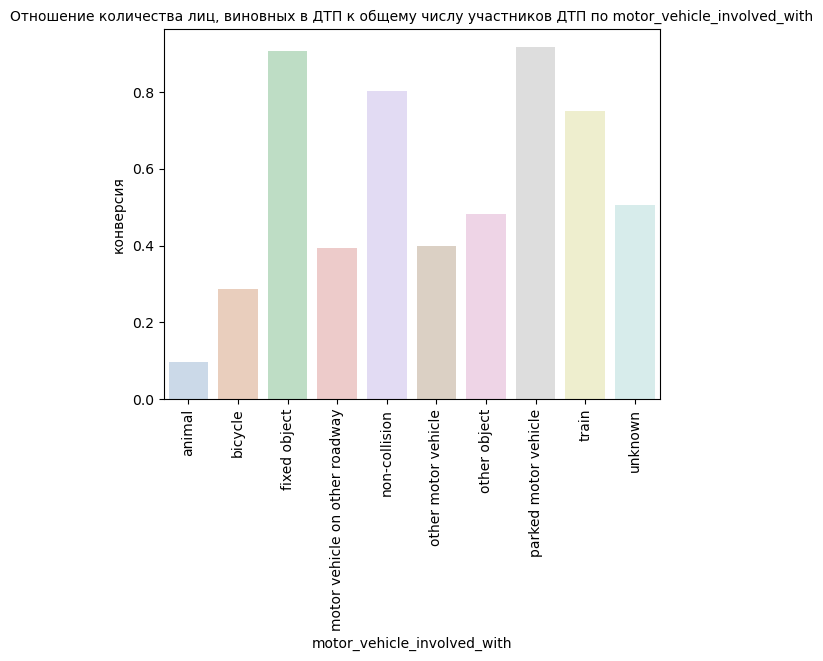

In [86]:
get_grath_convers(data=df, x='motor_vehicle_involved_with', y='at_fault')

**Вывод** - Отношение виновных лиц в ДТП к общему числу участников ДТП меняется в зависимости от группы в столбце motor_vehicle_involved_with, что выглядит вполне логичным. 

### Рассмотрим стобцы road_surface и road_condition. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown. Эти два фактора могут оказывать существенное влияние.

In [87]:
df['road_surface'].value_counts()

dry         50155
wet          5239
snowy         357
slippery       43
Name: road_surface, dtype: int64

In [88]:
df['road_condition'].value_counts()

normal            53969
construction        999
obstruction         248
other               228
holes               222
loose material      128
reduced width        72
flooded              32
Name: road_condition, dtype: int64

In [89]:
df[['road_condition', 'road_surface']] = df[['road_condition', 'road_surface']].fillna('unknown')
df[['road_condition', 'road_surface']].isna().sum()

road_condition    0
road_surface      0
dtype: int64

### Рассмотрим стобец lighting. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown. Этот столбец также может оказать существенное влияние.

In [90]:
df['lighting'].value_counts()

daylight                                   37984
dark with street lights                    11006
dark with no street lights                  5094
dusk or dawn                                1769
dark with street lights not functioning      135
Name: lighting, dtype: int64

In [91]:
df['lighting'] = df['lighting'].fillna('unknown')
df['lighting'].isna().sum()

0

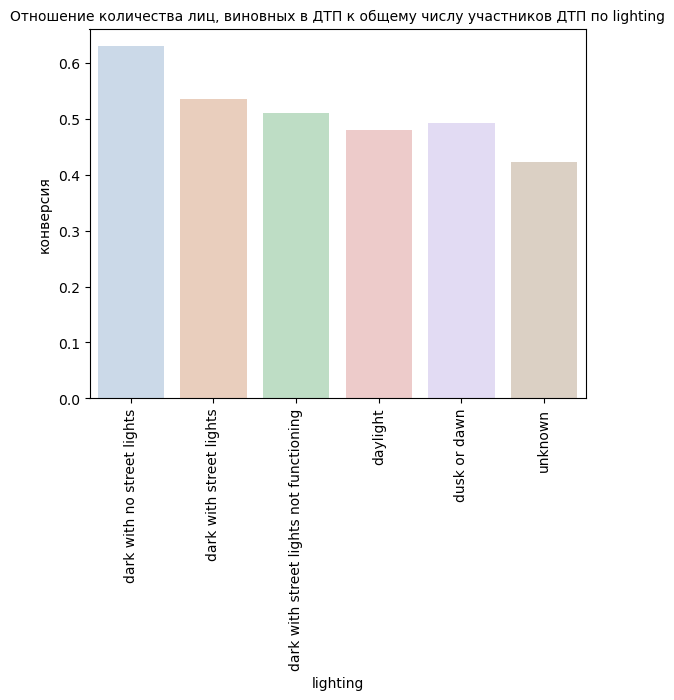

In [92]:
get_grath_convers(data=df, x='lighting', y='at_fault')

**Вывод** - осталяем данный признак.

### Рассмотрим стобец control_device. Посмотрим уникальные значения и их количество, заполним пропуски значением unknown. 

In [93]:
df['control_device'].value_counts()

none               37501
functioning        18281
not functioning      116
obscured              29
Name: control_device, dtype: int64

In [94]:
df['control_device'] = df['control_device'].fillna('unknown')
df['control_device'].isna().sum()

0

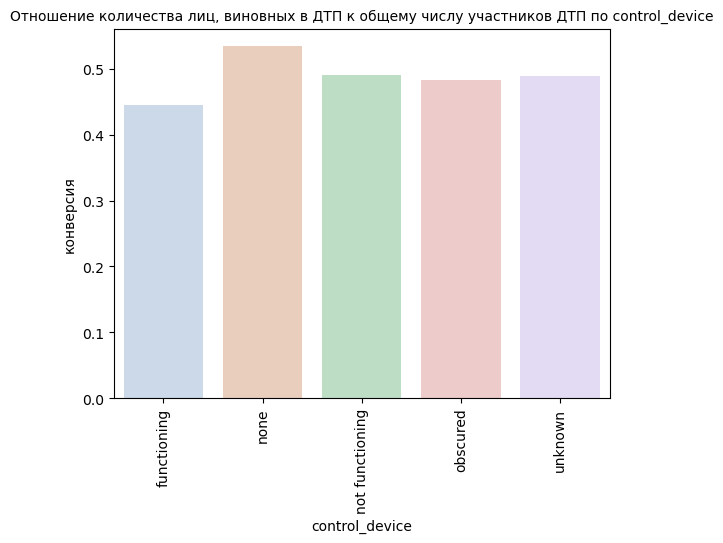

In [95]:
get_grath_convers(data=df, x='control_device', y='at_fault')

Скорее всего можно небольшое количество из категории obscured перевести в категорию not functioning.

In [96]:
df['control_device'] = df['control_device'].str.replace('obscured', 'not functioning')
df['control_device'].unique()

array(['none', 'functioning', 'unknown', 'not functioning'], dtype=object)

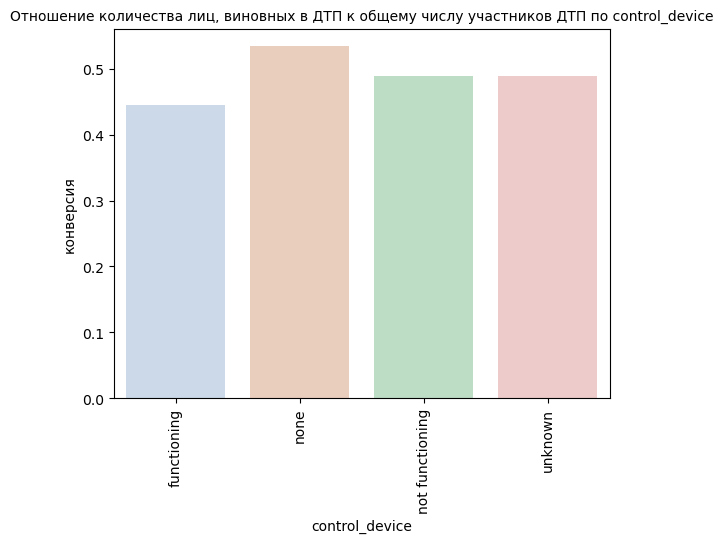

In [97]:
get_grath_convers(data=df, x='control_device', y='at_fault')

**Вывод** - оставим данный признак.

### Рассмотрим month.  Построим график конверсии (отношение количества лиц, виновных в ДТП к общему числу участников дтп) по каждому уникальному значению в столбце month.

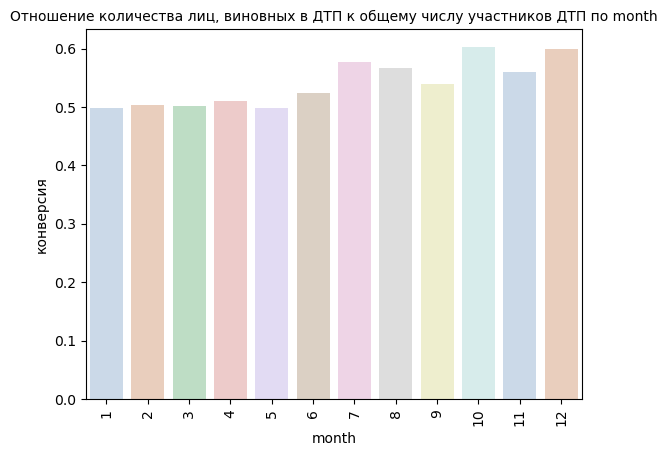

In [98]:
get_grath_convers(data=df, x='month', y='at_fault')

In [99]:
df['month'] = df['month'].astype('category')

**Вывод** - пока оставим данный признак, коллебания есть, но они не значительные.

### Рассмотрим столбец hour. В данном столбце есть пропуски, восстановить их не удасться, удалим данные значения. Изменим тип данных в столбце на int. Оставляем столбец, тюкю время происшествия может влиять.

In [100]:
df = df.query('not (hour.isna())')
df.shape

(56054, 22)

In [101]:
df['hour'] = df['hour'].astype('int8')
df['hour'].unique()

array([15,  6, 18, 10,  7, 20, 13,  8, 16, 23, 14,  1, 21, 12, 17, 11, 19,
        9,  0, 22,  3,  4,  2,  5], dtype=int8)

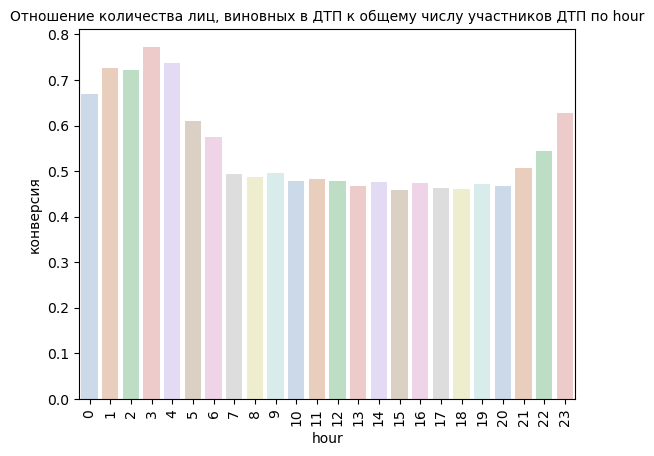

In [102]:
get_grath_convers(data=df, x='hour', y='at_fault')

### Рассмотрим vehicle_type. Посмотрим на уникальные значения.

In [103]:
df['vehicle_type'].value_counts()

sedan    37096
coupe    18954
other        4
Name: vehicle_type, dtype: int64

### Рассмотрим столбец vehicle_transmission. Посмотрим на уникальны значения. В данном столбце есть пропуски, заполним их unknown. 

In [104]:
df['vehicle_transmission'].value_counts()


manual    29205
auto      25992
Name: vehicle_transmission, dtype: int64

In [105]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('unknown')
df['vehicle_transmission'].isna().sum()

0

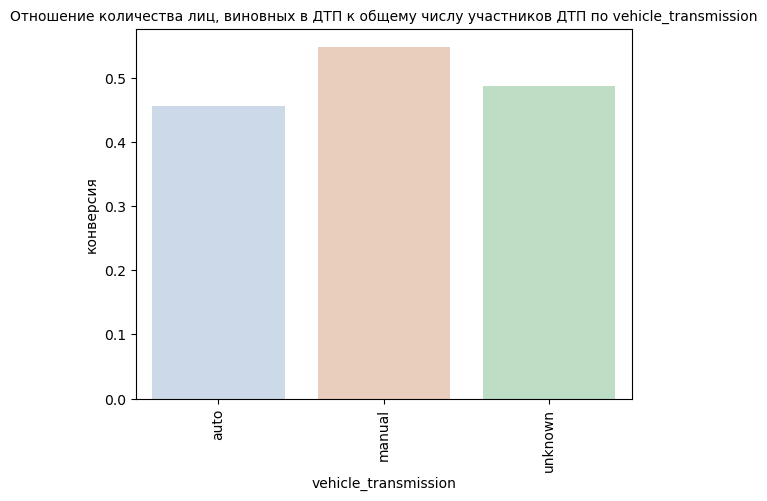

In [106]:
get_grath_convers(data=df, x='vehicle_transmission', y='at_fault')

**ВЫвод**- оставляем данный столбец

### Рассмотрим vehicle_age, здесь также наблюдаются выбросы (машины возрастом более 12 лет), также есть анамальные значения. Посмотрим уникальные значения и их количество. 

In [107]:
df['vehicle_age'].value_counts()

3.0      10976
4.0       7127
2.0       6033
5.0       5539
6.0       3926
7.0       3825
8.0       3497
0.0       3081
9.0       2756
1.0       2540
10.0      1934
11.0      1376
12.0       879
13.0       548
14.0       280
15.0        37
16.0         6
17.0         3
161.0        2
19.0         1
Name: vehicle_age, dtype: int64

Машины 14 лет и старше объеденим в одну категорию. Переведем тип столбца в object. Пропуски заполним unknown.

In [108]:
df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 14 if x>13 else x)


In [109]:
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median())
df['vehicle_age'].isna().sum()

0

In [110]:
df['vehicle_age'] = df['vehicle_age'].astype('int')
df['vehicle_age'] = df['vehicle_age'].astype('category')

In [111]:
df['vehicle_age'].value_counts()

3     10976
4      8815
2      6033
5      5539
6      3926
7      3825
8      3497
0      3081
9      2756
1      2540
10     1934
11     1376
12      879
13      548
14      329
Name: vehicle_age, dtype: int64

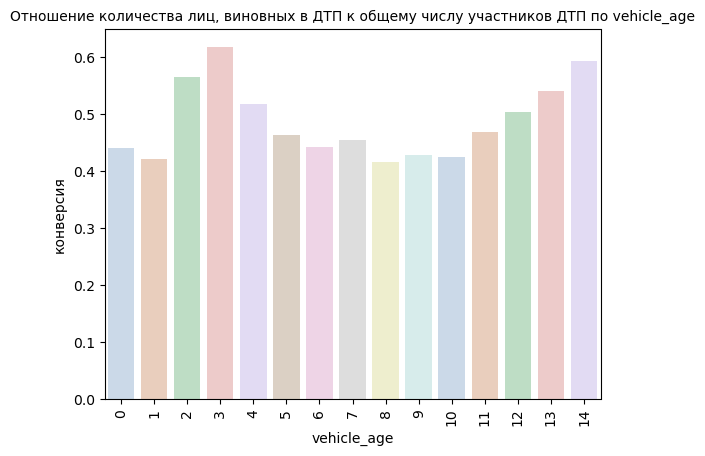

In [112]:
get_grath_convers(data=df, x='vehicle_age', y='at_fault')

### Рассмотри столбец insurance_premium, тут наблюдаются пропуски (547). Также необходимо изменить тип данных данного столбца на int. Так как не понятна причина отсутсвия данных (у этих участников нет страховки или просто не внесли данные и т.п.), то лучше удалим пропуски, они составляют около 1 % от данных.

In [113]:
df = df.query('not (insurance_premium.isna())')
df.shape

(55509, 22)

In [114]:
df['insurance_premium'] = df['insurance_premium'].astype('int32')

### Посмотрим, что получилось в итоге.

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55509 entries, 0 to 56223
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   at_fault                     55509 non-null  int64   
 1   insurance_premium            55509 non-null  int32   
 2   party_sobriety               55509 non-null  object  
 3   party_drug_physical          55509 non-null  object  
 4   cellphone_in_use             55509 non-null  category
 5   direction                    55509 non-null  object  
 6   weathe                       55509 non-null  object  
 7   location_type                55509 non-null  object  
 8   collision_damage             55509 non-null  object  
 9   party_count                  55509 non-null  category
 10  pcf_violation_category       55509 non-null  object  
 11  type_of_collision            55509 non-null  object  
 12  motor_vehicle_involved_with  55509 non-null  object  
 13  r

In [116]:
columns = df.select_dtypes(include='object').columns

In [117]:
for col in columns:
    df[col] = df[col].astype('category')


In [118]:
df['hour'] = df['hour'].astype('category')   
    

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55509 entries, 0 to 56223
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   at_fault                     55509 non-null  int64   
 1   insurance_premium            55509 non-null  int32   
 2   party_sobriety               55509 non-null  category
 3   party_drug_physical          55509 non-null  category
 4   cellphone_in_use             55509 non-null  category
 5   direction                    55509 non-null  category
 6   weathe                       55509 non-null  category
 7   location_type                55509 non-null  category
 8   collision_damage             55509 non-null  category
 9   party_count                  55509 non-null  category
 10  pcf_violation_category       55509 non-null  category
 11  type_of_collision            55509 non-null  category
 12  motor_vehicle_involved_with  55509 non-null  category
 13  r

**Вывод** - провели анализ данных в датафрейме, подготовили итоговую таблицу с данными, на которых будем обучать модель. Убрали лишние признаки, обработал пропуски, привели типы данных в соответствие.

In [120]:
df.duplicated().sum()

55

In [121]:
df= df.drop_duplicates().reset_index(drop=True)
len(df)

55454

### Подготовим выборки для обучения и тестирования моделей. Разобьем наши данные на обучающую и тестовую в соотношении 75 - 25. Целевой признак - at_fault, удаляем его из признаков.

In [122]:
features_train, features_test, target_train, target_test = train_test_split(df.drop('at_fault', axis=1), 
          df.at_fault, test_size=0.25, random_state=RANDOM_STATE)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
target_test.shape

(41590, 21)
(13864, 21)
(41590,)


(13864,)

### Определим категориальные и количественные признаки

In [123]:
cat_columns = features_train.select_dtypes(include='category').columns
num_columns = features_train.select_dtypes(include='number').columns
print(cat_columns)
num_columns

Index(['party_sobriety', 'party_drug_physical', 'cellphone_in_use',
       'direction', 'weathe', 'location_type', 'collision_damage',
       'party_count', 'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition',
       'lighting', 'control_device', 'month', 'hour', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object')


Index(['insurance_premium'], dtype='object')

### Исследуем модель случайный лес.

#### Создадим Column_transformer (для кодирования будем использовать OrdinalEncoder, StandardScaler) для модели случайный лес, затем pipline и с помощью RandomizedSearchCV будем подбирать гиперпараметры. Используемая метрика для отслеживания -  recall, т.к. нам важна полнота выявления класса 1, но потом посмотрим и другие метрики, например f1 (чтобы посмотреть сбалансированность полноты и точности) и roc_auc для сравнения со случайной моделью. 

In [124]:
column_transformer_rforest = make_column_transformer((StandardScaler(),num_columns), 
                                                     (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
                                                      , cat_columns),
                                                     remainder = 'passthrough')

In [125]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
pipline_rf = make_pipeline(column_transformer_rforest, model_rf)
pipline_rf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['insurance_premium'], dtype='object')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['party_sobriety', 'party_drug_physical', 'cellphone_in_use',
       'direction', 'weathe', 'location_type', 'collision_damage',
       'party_count', 'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition',
       'lighting', 'control_device', 'month', 'hour', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=12))])

In [126]:
param_rf = {
    'randomforestclassifier__n_estimators': range(10, 100, 10),
    'randomforestclassifier__max_depth': range(1, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}

grid_rf = RandomizedSearchCV(
    pipline_rf, 
    param_rf, 
    n_iter=100,
    cv=5,
    verbose=5,
    scoring='recall', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)
grid_rf

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               Index(['insurance_premium'], dtype='object')),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               Index(['party_sobriety', 'party_drug_physical', 'cellphone_...
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=12))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(1, 15),
                                        'randomforestclassifier__min_samples_leaf': (1,
                                                                                     2,
                                                                                     3,
                                                                                     4),
                                        'randomforestclassifier__min_samples_split': (2,
                                                                                      3,
                                                                                      4),
                                        'randomforestclassifier__n_estimators': range(10, 100, 10)},
                   random_state=12, scoring='recall', verbose=5)

In [127]:
%%time
start_time_rf = time.time()
grid_rf.fit(features_train, target_train)
end_time_rf = time.time()
fit_time_rf = end_time_rf - start_time_rf
print(fit_time_rf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
105.93753838539124
Wall time: 1min 45s


In [128]:
grid_rf.best_params_

{'randomforestclassifier__n_estimators': 10,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_depth': 14}

In [129]:
recall_rf = grid_rf.best_score_
recall_rf

0.5861230355614627

### Исследуем модель LogisticRegression. 

#### Создадим Column_transformer (для кодирования будем использовать OneHotEncoder, StandardScaler) для модели логистической регрессии, затем pipline и с помощью RandomizedSearchCV будем подбирать гиперпараметры. Используемая метрика для отслеживания - recall, т.к. нам важна полнота выявления класса 1, но потом посмотрим и другие метрики, например f1 (чтобы посмотреть сбалансированность полноты и точности) и roc_auc для сравнения со случайной моделью.¶

In [130]:
column_transformer_lr = make_column_transformer((StandardScaler(),num_columns), 
                                                     (OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
                                                      , cat_columns),
                                                     remainder = 'passthrough')
model_lr = LogisticRegression(random_state=RANDOM_STATE,  penalty='l1')
pipline_lr = make_pipeline(column_transformer_lr, model_lr)
pipline_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['insurance_premium'], dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['party_sobriety', 'party_drug_physical', 'cellphone_in_use',
       'direction', 'weathe', 'location_type', 'collision_damage',
       'party_count', 'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition',
       'lighting', 'control_device', 'month', 'hour', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object'))])),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=12))])

In [131]:
param_lr = {
          'logisticregression__solver': ['lbfgs', 'liblinear'],
          'logisticregression__max_iter': range(100, 1001, 100)
}


grid_lr = RandomizedSearchCV(
    pipline_lr, 
    param_lr, 
    n_iter=100,
    cv=5,
    verbose=5,
    scoring='recall', 
    n_jobs=-1, 
    random_state=RANDOM_STATE)
start_time_lr = time.time()
grid_lr.fit(features_train, target_train)
end_time_lr = time.time()
fit_time_lr = end_time_lr - start_time_lr
print(fit_time_lr)

C:\Users\bniko\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\bniko\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bniko\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bniko\anaconda3\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\bniko\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty,

292.4878625869751


In [132]:
grid_lr.best_params_

{'logisticregression__solver': 'liblinear',
 'logisticregression__max_iter': 100}

In [134]:
recall_lr = grid_lr.best_score_
recall_lr

0.5884210835289402

### Исследуем модель CatBoostClassifier

#### Ищем лучшие параметры модели

In [165]:
%%time
train_dataset = Pool(features_train, target_train, cat_features = ['party_sobriety', 'party_drug_physical', 'cellphone_in_use',
                                                             'direction', 'weathe', 'location_type', 'collision_damage',
       'party_count', 'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition',
       'lighting', 'control_device', 'month', 'hour', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age']) 
model_ct = CatBoostClassifier(random_seed=RANDOM_STATE, loss_function ='Logloss', silent=True, eval_metric='Recall')
grid = {'learning_rate': [0.1, 0.3],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [150, 200, 400]}
start_time_cb = time.time()
model_ct.randomized_search(grid, train_dataset)
end_time_cb = time.time()
fit_time_cb = end_time_cb - start_time_cb
print(fit_time_cb)


bestTest = 0.6156566847
bestIteration = 105

0:	loss: 0.6156567	best: 0.6156567 (0)	total: 15.3s	remaining: 2m 18s

bestTest = 0.6128271634
bestIteration = 1

1:	loss: 0.6128272	best: 0.6156567 (0)	total: 30.8s	remaining: 2m 3s

bestTest = 0.6203725536
bestIteration = 175

2:	loss: 0.6203726	best: 0.6203726 (2)	total: 54.2s	remaining: 2m 6s

bestTest = 0.6088186748
bestIteration = 194

3:	loss: 0.6088187	best: 0.6203726 (2)	total: 1m 17s	remaining: 1m 56s

bestTest = 0.6276821504
bestIteration = 325

4:	loss: 0.6276822	best: 0.6276822 (4)	total: 2m 5s	remaining: 2m 5s

bestTest = 0.6305116718
bestIteration = 255

5:	loss: 0.6305117	best: 0.6305117 (5)	total: 2m 54s	remaining: 1m 56s

bestTest = 0.618957793
bestIteration = 137

6:	loss: 0.6189578	best: 0.6305117 (5)	total: 3m 12s	remaining: 1m 22s

bestTest = 0.6335769866
bestIteration = 139

7:	loss: 0.6335770	best: 0.6335770 (7)	total: 3m 31s	remaining: 52.8s

bestTest = 0.6243810422
bestIteration = 175

8:	loss: 0.6243810	best: 0.63

In [141]:
recall_cb = 0.6682947852


  {'params': {'depth': 10,
  'l2_leaf_reg': 1,
  'iterations': 400,
  'learning_rate': 0.3},

### Исследуем модель LGBMClassifier

#### Ищем лучшие параметры модели с помощью RandomizedSearchCV

In [142]:
model_lg = LGBMClassifier(random_seed=RANDOM_STATE)

params_lg = {
    'num_leaves': range(10,100,10),
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
}
grid_lg = RandomizedSearchCV(model_lg,
                         params_lg,
                         n_iter=40,
                         cv=5,
                         scoring='recall',
                         verbose=False)

In [143]:
%%time
start_time_lg = time.time()
grid_lg.fit(features_train, target_train)
end_time_lg = time.time()
fit_time_lg = end_time_lg - start_time_lg
print(fit_time_lg)

C:\Users\bniko\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 36 is smaller than n_iter=40. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008536
[LightGBM] [Info] Start training from score 0.008536
[LightGBM] [Info] Number of positive: 16707, number of negative: 16565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 33272, number of used features: 21
[LightGBM] [Info] [bin

[LightGBM] [Info] Number of positive: 20883, number of negative: 20707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 41590, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502116 -> initscore=0.008464
[LightGBM] [Info] Start training from score 0.008464
53.83035206794739
Wall time: 53.8 s


In [144]:
grid_lg.best_params_

{'num_leaves': 70, 'learning_rate': 0.5}

In [148]:
recall_lg = grid_lg.best_score_
recall_lg

0.66264450369979

In [163]:
model_lg = grid_lg.best_estimator_
model_lg

LGBMClassifier(learning_rate=0.5, num_leaves=70, random_seed=12)

### Анализ моделей
Для удобства сравнения сведем все нужные параметры в одну таблицу

In [171]:
index = ['RandomForestClassifier',
         'LogisticRegression',
         'CatBoostClassifier',
         'LGBMClassifier']
data = {'Recall':[recall_rf, recall_lr, recall_cb, recall_lg],
        'Время обучения модели, сек':[fit_time_rf, fit_time_lr, fit_time_cb, fit_time_lg]
       }
                                          

compare = pd.DataFrame(data=data, index=index)
display(compare)

,Recall,"Время обучения модели, сек"
RandomForestClassifier,0.586123,105.937538
LogisticRegression,0.588421,292.487863
CatBoostClassifier,0.668295,960.871729
LGBMClassifier,0.662645,53.830352


**Вывод** - Нами были исследованы 4 вида моделей 'RandomForestClassifier', 'LogisticRegression','CatBoostClassifier',     'LGBMClassifier'. Лучшие результ показала модель CatBoostClassifier и LGBMClassifier, у них практически олинаковые показатели по качеству. Проверим их на тесте. 

Проверка модели 'LGBMClassifier' на тестовой выборке.

In [164]:
prediction_lg_test = model_lg.predict(features_test)
recall_lg_test = recall_score(target_test, prediction_lg_test)
f1_lg_test = f1_score(target_test, prediction_lg_test)
roc_auc_lg_test = roc_auc_score(target_test, model_lg.predict_proba(features_test)[:, 1])
print('Recall:', recall_lg_test, 'f1:', f1_lg_test, 'ROC_AUC:', roc_auc_lg_test)

Recall: 0.6599971210594501 f1: 0.6957511380880121 ROC_AUC: 0.7966242538691981


Проверка модели 'CatBoostClassifier' на тестовой выборке.

In [172]:
prediction_cb_test = model_ct.predict(features_test)
recall_cb_test = recall_score(target_test, prediction_cb_test)
f1_cb_test = f1_score(target_test, prediction_cb_test)
roc_auc_cb_test = roc_auc_score(target_test, model_cb.predict_proba(features_test)[:, 1])
print('Recall:', recall_cb_test, 'f1:', f1_cb_test, 'ROC_AUC:', roc_auc_cb_test)

Recall: 0.6604289621419318 f1: 0.7017973231357553 ROC_AUC: 0.8056315877173998


**Итоговый вывод по сравнению моделей:** Показатели модель 'CatBoostClassifier' на тесте лучше, выбираем ее.

### Проведем анализ качества модели CatBoostClassifier.  Посчитаем «Матрицу ошибок», отоброзим ее на графике.  Выведем полноту и точность на график.

#### Посчитаем "Матрицу ошибок"

In [153]:
cm_cb = confusion_matrix(target_test, prediction_cb_test)
print('Confusion matrix\n\n', cm_cb)
print('\nTrue Positives(TP) = ', cm_cb[0,0])
print('\nTrue Negatives(TN) = ', cm_cb[1,1])
print('\nFalse Positives(FP) = ', cm_cb[0,1])
print('\nFalse Negatives(FN) = ', cm_cb[1,0])

Confusion matrix

 [[5377 1540]
 [2359 4588]]

True Positives(TP) =  5377

True Negatives(TN) =  4588

False Positives(FP) =  1540

False Negatives(FN) =  2359


#### Представим матрицу ошибок графически

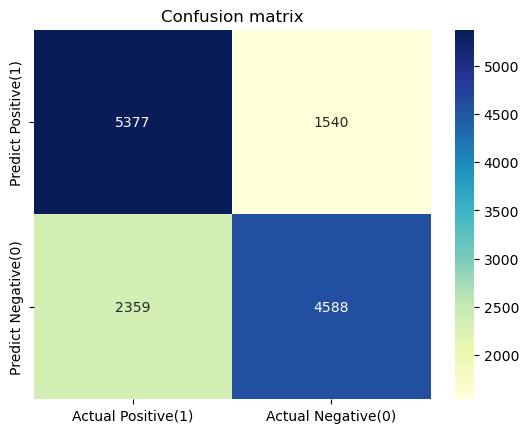

In [154]:
cm_matrix = pd.DataFrame(data=cm_cb, columns=['Actual Positive(1)', 'Actual Negative(0)'], 
                                 index=['Predict Positive(1)', 'Predict Negative(0)'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion matrix')
plt.show()

Мы видим, что модель неплохо предсказывает как положительный, так и отрицательный класс, но положительный класс предсказывает не достаточно хорошо. Число положительный ответов надо увеличить, увеличение ложно положительный ответов для нас не так критично, как большое число ложно отрицательных ответов для целей нашей задачи. Попробуем снизить порог определения класса, подобрав оптимальный порог.

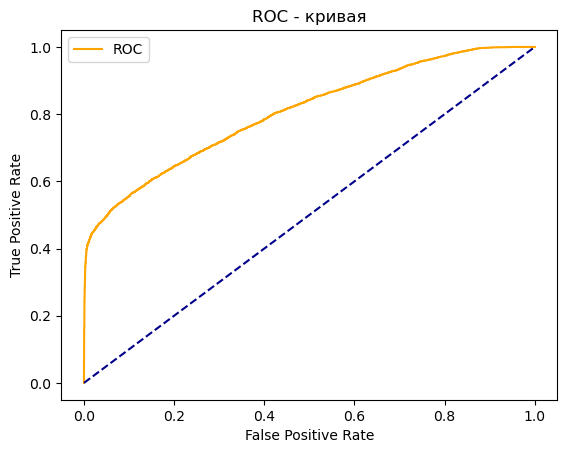

In [157]:
fpr, tpr, thresholds = roc_curve(target_test, model_ct.predict_proba(features_test)[:, 1])
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - кривая')
plt.legend()
plt.show()


Попробуем поменять порог в сторону уменьшения, при 0.35 получаем неплохие результаты.

In [156]:
print('Recall', recall_score(target_test, model_ct.predict_proba(features_test)[:, 1]>=0.35))
print('Precision', precision_score(target_test, model_ct.predict_proba(features_test)[:, 1]>=0.35))
print('F1', f1_score(target_test, model_ct.predict_proba(features_test)[:, 1]>=0.35))
print('roc_au', roc_auc_score(target_test, model_ct.predict_proba(features_test)[:, 1]>=0.35))

Recall 0.7627752986900821
Precision 0.6759790789641535
F1 0.7167590964425807
roc_au 0.6977820399768178


#### Построим кривую Precision-Recall

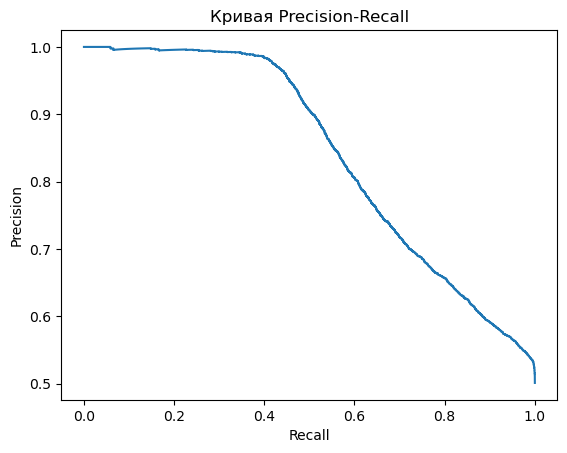

In [158]:
precision, recall, thresholds = precision_recall_curve(target_test, model_ct.predict_proba(features_test)[:, 1])
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.show()

**Вывод** Выбранная нами модель CatBoostClassifier с лучшими показателями модели на тестовой выборке дает не плохой результат, но больше ошибается в определении положительного класса. лучше уменьшить порог, тогда recall увеличивается при этом другие параметры тоже остаются приемлимыми.

## Проведите анализ важности факторов ДТП

### Посмотри, какие факторы были наиболее важными для лучшей модели

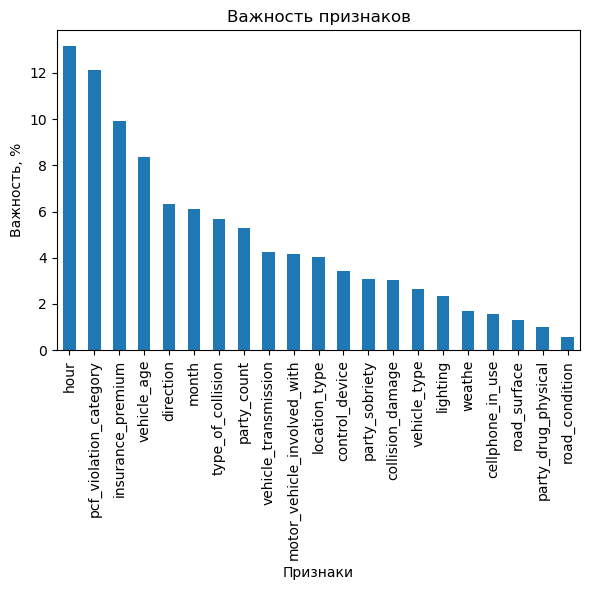

In [159]:
features_importance_cb = pd.Series(model_cb.get_feature_importance(),
                         (features_train).columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(6, 6))
features_importance_cb.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
ax.set_xlabel('Признаки')
fig.tight_layout()

**Вывод** Из полученного графика видим, что наиболее важными признаками для модели были время происшествия, категория нарушения, сумма страховки, возраст автомобиля и число участников. 

### Проанализируем зависимость фактора время происшествия и количество происшествий.

In [160]:
def get_grath_convers (data, x, y):
    dt = df.groupby(x)[y].mean().reset_index()
    sns.barplot(x=dt[x], y=dt[y], palette=colors, saturation=0.5, alpha=0.7)
    plt.title(f'Отношение количества лиц, виновных в ДТП к общему числу участников ДТП по {x}', fontsize=10)
    plt.ylabel('конверсия')
    plt.xticks(rotation=90)
    plt.show()

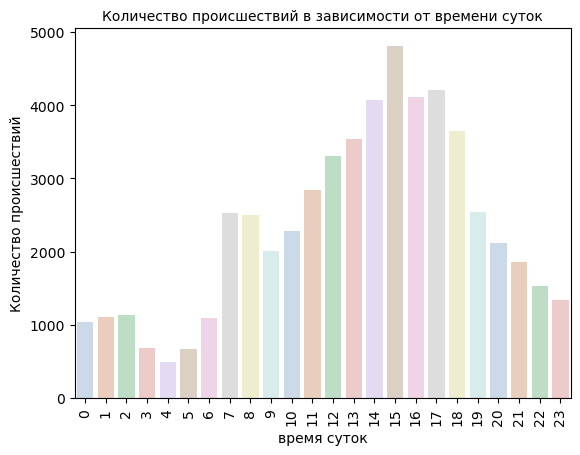

In [161]:
df_count = df.groupby('hour')['at_fault'].count().reset_index()
df_count
sns.barplot(x=df_count['hour'], y=df_count['at_fault'], palette=colors, saturation=0.5, alpha=0.7)
plt.title(f'Количество происшествий в зависимости от времени суток', fontsize=10)
plt.ylabel('Количество происшествий')
plt.xlabel ('время суток')
plt.xticks(rotation=90)
plt.show()

### Еще раз построим график отношения лиц, виновных в ДТП к общему числу ДТП в зависимости от времени суток.

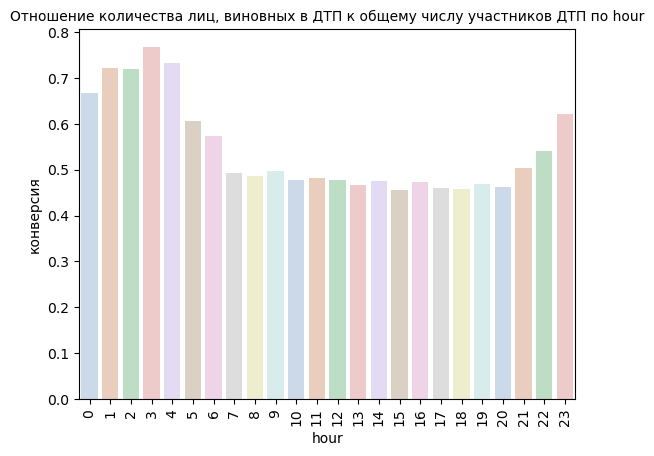

In [162]:
get_grath_convers(df, 'hour', 'at_fault')

**Вывод:** Проанализировав данные графики видим, что наибольшее количество ДТП приходится на часы с 14 до 17, видимо в это время наблюдается самый высокий трафик. При этом соотношение лиц виновных в ДТП к общему числу участников ДТП выше как раз в ночное время с 11 вечера до 4 утра, что как раз может быть обусловлено усталостью водителя, плохой видимостью и т.п. При этом количество самих ДТП в это время меньше. Например, в ночное время модно порекомендовать использовать для водителей приборы типа 'антисон', оборудовать машины приборами бокового интервала или подобными, которые бы при опсаном сближении или нехарактерном управлении водителем машины подвали соответсвующий сигнал.

## Выводы

В качестве лучшей модели была выбрана модель CatBoostClassifier с лучшими показателями модели на тестовой выборке -Recall: 0.6604289621419318 f1: 0.7017973231357553 ROC_AUC: 0.8056315877173998. Модель не достаточно хорошо предсказывает положительный класс, так как достаточно много ложноотрицательных ответов для поставленной перед нами задачей. Это можно откорректировать уменьшением порога классификацимми. Например при снижении порога до 0.35, величина recall увеличивается до - 0.7627752986900821, при этом остальные метрики остаются довольно приличными (Precision 0.6759790789641535,F1 0.7167590964425807, roc_au 0.6977820399768178).

Я считаю, что на предоставленных данных нельзя оценить риск попадания в ДТП, т.к. данные содержать информацию только о ситуациях, лицах и транспортных средствах уже попавших в ДТП. Вариант таргета, который предлагает заказчик, позволяет оценить вероятность виновности водителя в ДТП, но не сам риск попадания в ДТП. Оценка признака 'hour' наглядно это показывает. Вероятность попасть в ДТП выше в дневные часы (исходим из соотношения количества ДТП в определенный час), а вероятность стать виновником ДТП выше в ночные часы. Например, заснуть и врезаться в ограждение или другой предмет на дороге. Поэтому для корректной оценки вероятности ДТП все-таки необходимы данные, как о лицах, попавших в ДТП, так и лицах с безаварийными поездками. Например, база данных по поездкам самой каршеринговой компании. 